# Plankton Challenge
We address the plankton challenge following the *Image classification* path. This requires the exploration of computer vision topics and the usage of CNNs.

The section of the notbook the following:
- **1. Data Exploration**
- **2. Data Pre Processing**
- **3. Model Selection**
- **4. Paramters Optimization**
- **5. Model Evaluation**

Import used libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile

from math import isnan, log, exp
from io import BytesIO
from PIL import Image
from tqdm import tqdm

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score

np.set_printoptions(precision=2)

Import PyTorch functions

In [2]:
# Torch import block
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.functional import nll_loss
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader

In [3]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

##### Metadata
Store the base directory of the dataset into a variable

In [4]:
# Base path of the plankton datasets
base_dir = '/mnt/datasets/plankton/flowcam/'
meta_ = 'meta.csv'

In [5]:
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

##### Utility Functions
Below there are some function used in the notebook. They are self documented, but their usage within our work is explained when they are explicitely used..

In [6]:
# Utility Functions

# Function given in the description of the problem
def extract_zip_to_memory(input_zip):
    """
    This function extracts the images stored inside the given zip file.
    It stores the result in a python dictionary.
    
    input_zip (string): path to the zip file
    
    returns (dict): {filename (string): image_file (bytes)}
    """
    input_zip = zipfile.ZipFile(input_zip)
    return {name: BytesIO(input_zip.read(name)) for name in input_zip.namelist() if name.endswith('.jpg')}


def update_confusion_matrix(confusion_matrix, output, target, n_classes=39):
    """Update the confusion matrix"""
    _, preds = torch.max(output, 1)
    for t, p in zip(target.view(-1), preds.view(-1)):
        confusion_matrix[t.long(), p.long()] += 1

def build_per_class_accuracies(confusion_matrix):
    """Return an array of accuracies for each class"""
    diags = np.diag(confusion_matrix)
    rows_sum = confusion_matrix.sum(axis=1)
    class_accuracies = []
    for d, r in zip(diags, rows_sum):
        # True Positive
        n_classified_correctly = d
        # True Positive + False Negative
        row_sum = r
        # Accuracy for class i-th
        cl_accuracy = n_classified_correctly * 100 / row_sum
        class_accuracies.append(cl_accuracy)
        # print("Class Accuracy: {0}. True Positive: {1}. True Positive + False Negative: {2}".format(cl_accuracy, d, row_sum))
    # it will return false positive and false negative
    return class_accuracies

In [7]:
class ResizeSquare(object):
    """Resize the image to a given size.

     Args:
         output_size (int): Desired output size. If smaller of image edges is matched
             to output_size keeping aspect ratio the same.
     """
    
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.new_h = output_size
        self.new_w = output_size
        
    def __call__(self, image):
        
        w, h = image.size

        if w != h:
            dim = w if w > h else h
            # create a new square image dim x dim in gray scale
            sq_img = Image.new('L', (dim, dim), (255))
            offset = (int(round(((dim - w) / 2), 0)), int(round(((dim - h) / 2),0)))
            sq_img.paste(image, offset)
        else:
            sq_img = image
            
        return sq_img.resize((self.new_w, self.new_h), Image.ANTIALIAS)
    
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, image):
        
        image_array = np.array(image, dtype=np.float32)
        
        if len(image_array.shape) == 2:
            image_array = np.array([image_array])
        else:
            # swap color axis because
            # numpy image: H x W x C
            # torch image: C X H X W
            image_array = image_array.transpose((2, 0, 1))
        
        # swap black and white (white=0, black = 255)
        image_array = (255 - image_array) / 255
        
        return torch.from_numpy(image_array)

In [8]:
def get_data_loaders(inputs, targets, train_idx, val_idx, mapping, train_transformations, test_transformations, batch_size=128, sampler=None):
    train_dataset = PlanktonDataset(inputs.values[train_idx], targets.values[train_idx],
                                        img_files = img_files,
                                        label_mapping = mapping,
                                        transform = train_transformations,
                                        )
    if sampler != None:
        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=detritus_wrs, num_workers=4)
    else:
        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

    val_dataset = PlanktonDataset(inputs.values[val_idx], targets.values[val_idx],
                                            img_files = img_files,
                                            label_mapping = mapping,
                                            transform = test_transformations,
                                            )
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, num_workers=4)
    
    return train_dataloader, val_dataloader

In [9]:
def train_model(data_loader, model, optimizer, loss):
    data_loader_iterator = iter(data_loader)
    # setting the cululative loss to zero
    tot_loss = 0
    for i, sample in enumerate(data_loader_iterator):
        # Loading the image sample from data loader to selected device
        image = sample['image'].to(device)
        # Loading the injected features from data loader to selected device
        inj_features = sample['inj_features'].to(device)
        # Loading the targets of the sample (i.e. belonging classes) from data loader to selected device
        target = sample['label'].to(device)
        # Putting zero to all the gradients
        optimizer.zero_grad()

        # training operations
        output = model(image, inj_features)
        loss = loss_function(output, target)
        loss.backward()
        optimizer.step()
        # Cumulating loss
        tot_loss += loss.data.item()
    return tot_loss / (i + 1)

In [10]:
def test_model(data_loader, model, loss, n_classes):
    data_loader_iterator = iter(data_loader)
    # setting the cululative loss to zero
    tot_loss = 0
    correct = 0
    confusion_matrix = np.zeros((n_classes, n_classes))
    with torch.no_grad():
        for i, sample in enumerate(data_loader_iterator):
            # Loading the image sample from data loader to selected device
            image = sample['image'].to(device)
            # Loading the injected features from data loader to selected device
            inj_features = sample['inj_features'].to(device)
            # Loading the targets of the sample (i.e. belonging classes) from data loader to selected device
            target = sample['label'].to(device)

            # evaluating model
            output = model(image, inj_features)
            loss = loss_function(output, target)
            tot_loss += loss.data.item()
            pred = output.max(1, keepdim=True)[1]
            # update confusion matrix
            update_confusion_matrix(confusion_matrix, output, target, n_classes)
            correct += pred.eq(target.view_as(pred)).sum().item()
    # add b
    accuracies = build_per_class_accuracies(confusion_matrix)
    # THEN mean_acc = np.mean(accuracies)
    # end
    avg_loss_test = tot_loss / (i + 1)
    return correct, confusion_matrix, accuracies, avg_loss_test

## 1. Data Exploration
The challenge is a image classification problem, so we need to explore the data space. 
The main issue to be addressed is the class unbalancy as we will see that the number of object per label is tremendously unbalanced.

The file meta.csv is needed to keep track of the labels for each image

In [11]:
# Read metadata csv
raw_df = pd.read_csv(base_dir + 'meta.csv')

# remove all rows which have level2 == NaN
plankton_df = raw_df[~raw_df['level2'].isna()]

# cast objid to int32
plankton_df['objid'] = plankton_df['objid'].astype('int32', errors='ignore')

# keep just useful columns for the training phase (id, target)
plankton_df = plankton_df[['objid', 'level2']]

#### Class Unbalancy analysis

Classification problems tend to be easier when the labels are uniformly distributed across all possible classes. The code below plot the number of objects for each class, i.e. belonging species for each plankton image.

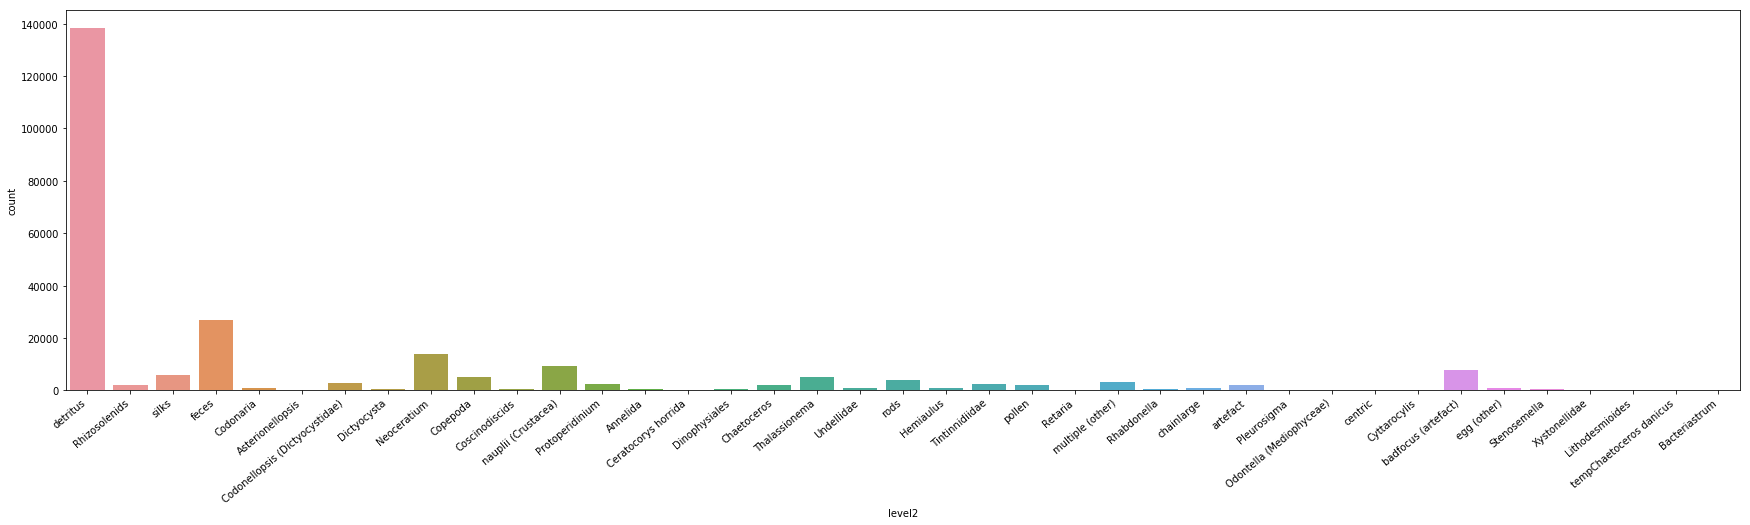

In [12]:
count_per_class = plankton_df.groupby('level2')['level2'].count().reset_index(name='count').sort_values(['count'], ascending=False)

# print distribution of classes in the dataset
fig, ax = plt.subplots(figsize=(30, 7))
sns.countplot(x='level2', data=plankton_df, orient='v', ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

plt.show()

The graph below shows the number of samples per class **without** detritus ones which are the most common.

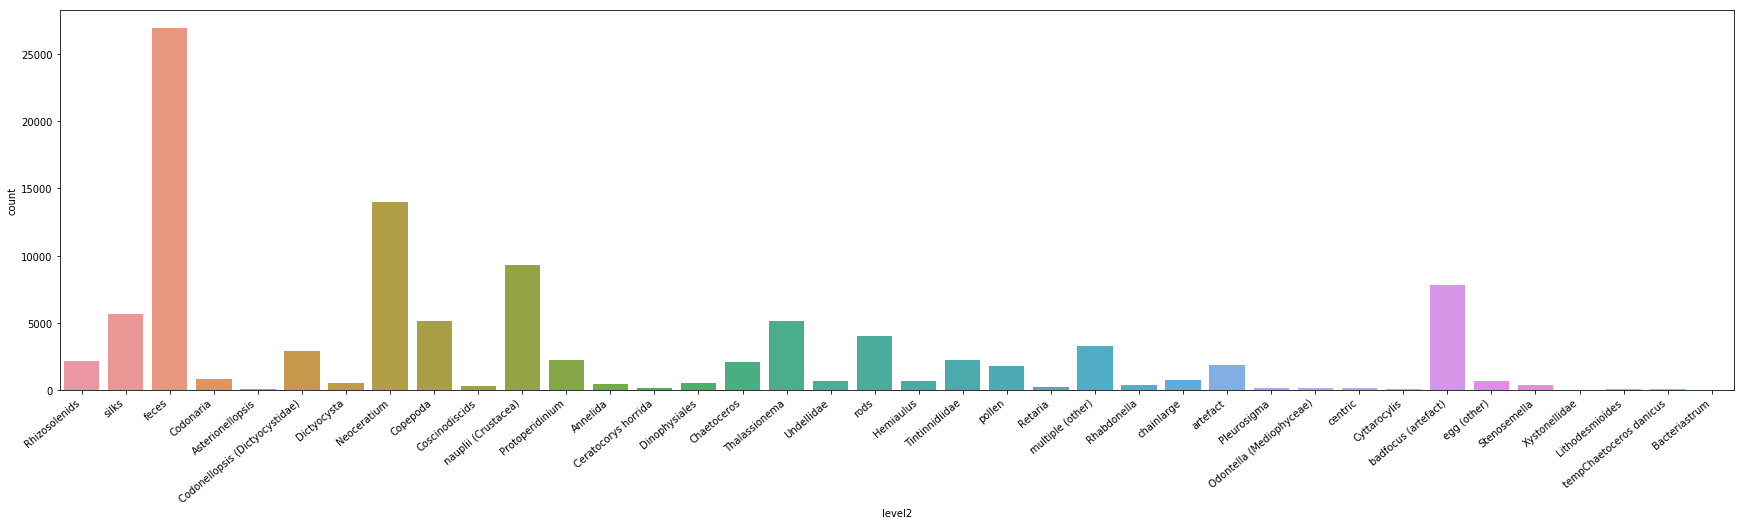

In [13]:
no_detritus_df = plankton_df[plankton_df['level2'] != 'detritus']

# print distribution of classes in the dataset
fig, ax = plt.subplots(figsize=(30, 7))
sns.countplot(x='level2', data=no_detritus_df, orient='v', ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

plt.show()

This is a clear example of **very** unbalanced dataset. It means that this issue should be treated carefully in the model selection. Without any adjustment, every model trained would be too biased towards the classification of detritus.

## 2. Data Pre-Processing

The image dataset is composed by different dimension images. This issue is addressed throught a careful analysis of the ***metrix*** of the sizes: width, height and area.

### Image size analysis

Due to the fully-connected layers (that usually come after the convolutional ones), the input needs to have a fixed dimension. Generally CNNs require **equal size** images, and the dataset contains images with different sizes.

In [15]:
# Extract images in memory
img_files = extract_zip_to_memory(base_dir + 'imgs.zip')

The shape of each image is stored into a numpy array. Mean and Std of sizes are stored into a csv.

In [ ]:
shapes = []
metadata = pd.read_csv(filepath_or_buffer=base_dir + 'meta.csv')
df = pd.DataFrame([], ['name', 'height', 'width', 'area']) #LOOOONG TO RUN

for k in tqdm(img_files.keys()):
    shape = np.array(Image.open(img_files[k])).shape
    shapes.append(shape)
    obj = k[5:-4]
    val = metadata[metadata['objid'] == int(obj)]['level2'].values[0]
    df = df.append({'name': val, 'height': shape[0], 'width': shape[1], 'area': shape[1] * shape[0]}, ignore_index=True)
# Convert the list to numpy
shapes = np.array(shapes)

result = df.groupby(['name'], as_index=False).agg({'height':['mean','std'],'width':['mean','std'], 'area':['mean','std']})

In the box below, we computed some relevant statistics related to the dimensions of images such as:
<ul>
    <li>max</li>
    <li>min</li>
    <li>mean</li>
    <li>median</li>
    <li>standard deviation</li>
</ul>

In [19]:
# Compute relevant statistic on width
max_x = max(shapes[:, 0])
min_x = min(shapes[:, 0])
mean_x = np.mean(shapes[:, 0])
median_x = np.median(shapes[:, 0])
std_x = np.std(shapes[:, 0])

# Compute relevant statistic on height
max_y = max(shapes[:, 1])
min_y = min(shapes[:, 1])
mean_y = np.mean(shapes[:, 1])
median_y = np.median(shapes[:, 1])
std_y = np.std(shapes[:, 1])

print("Min x: {0} Max x: {1} Mean x: {2} Median x: {3} Std x: {4}".format(min_x, max_x, round(mean_x, 2), median_x, round(std_x, 2)))
print("Min y: {0} Max y: {1} Mean y: {2} Median x: {3} Std y: {4}".format(min_y, max_y, round(mean_y, 2), median_y, round(std_y, 2)))

Min x: 2 Max x: 739 Mean x: 109.34 Median x: 87.0 Std x: 71.93
Min y: 2 Max y: 972 Mean y: 86.63 Median x: 67.0 Std y: 62.15


The same statistics are computed on the *area* of each image.

In [25]:
areas = shapes[:, 0] * shapes[:, 1]
# Compute relevant statistic on width
max_a = max(areas)
min_a = min(areas)
mean_a = np.mean(areas)
median_a = np.median(areas)
std_a = np.std(areas)

print("Min area: {0} Max area: {1} Mean area: {2} Median area: {3} Std area: {4}".format(min_a, max_a, round(mean_a, 2), median_a, round(std_a, 2)))

Min area: 12 Max area: 583792 Mean area: 11535.99 Median area: 5776.0 Std area: 19281.31


The above analysis concerns the *width* and *height* of images, while below we display as a 2-d density distribution the frequencies of the combination for each possible size

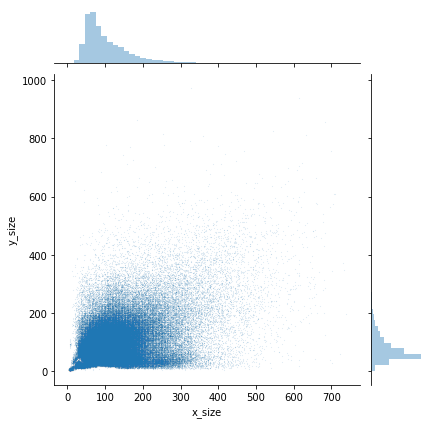

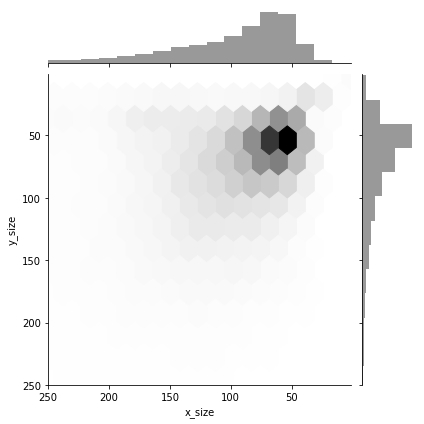

In [21]:
d = {'x_size' : shapes[:, 0], 'y_size': shapes[:, 1]}
df = pd.DataFrame(d)

g = sns.jointplot(x='x_size', y='y_size', data=df, s=0.002);
g1 = sns.jointplot(x=df['x_size'], y=df['y_size'], kind="hex", color="k", xlim=250, ylim=250)

We then store the metrics computed on the shapes of images for each class into a csv.

In [10]:
# Reading the csv with the metrics of shape of images for each class
df_dimensions = pd.read_csv('./dimensions_per_class.csv')
# The column 'name' is set as index
df_dimensions = df_dimensions.set_index(['name'])
# the method to_csv produced an empty line, so we remove it to avoid errors
df_dimensions = df_dimensions[~df_dimensions.index.isna()]
# Some value were stored as str, so everything is converted to float
df_dimensions = df_dimensions.astype('float')

In [15]:
# Dimension of each plot.
stnd_dim = (18, 5)

### Height, Width and Area
The graphs below show the correlations between the sizes of image and the belonging class.

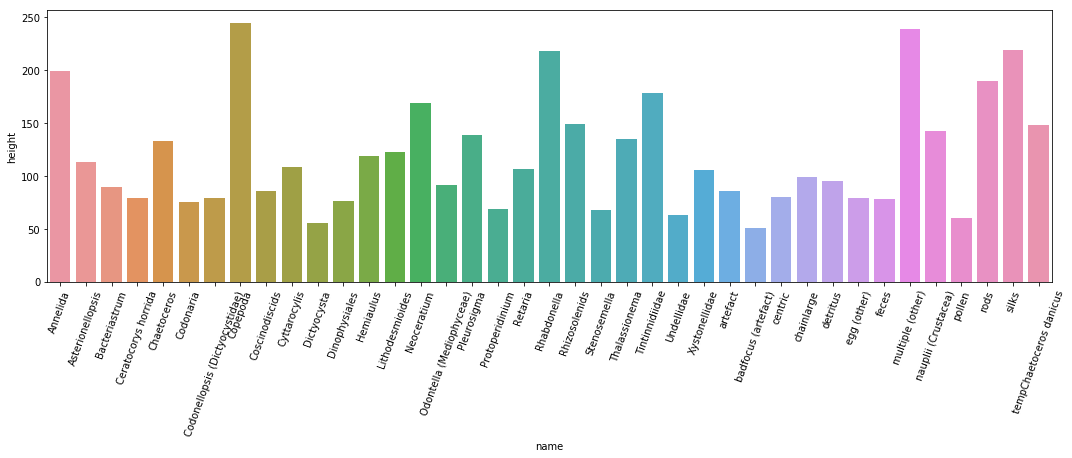

In [14]:
fig, ax = plt.subplots(figsize=stnd_dim)

g = sns.barplot(x=df.index, y=df_dimensions.height)
plt.xticks(rotation=70);

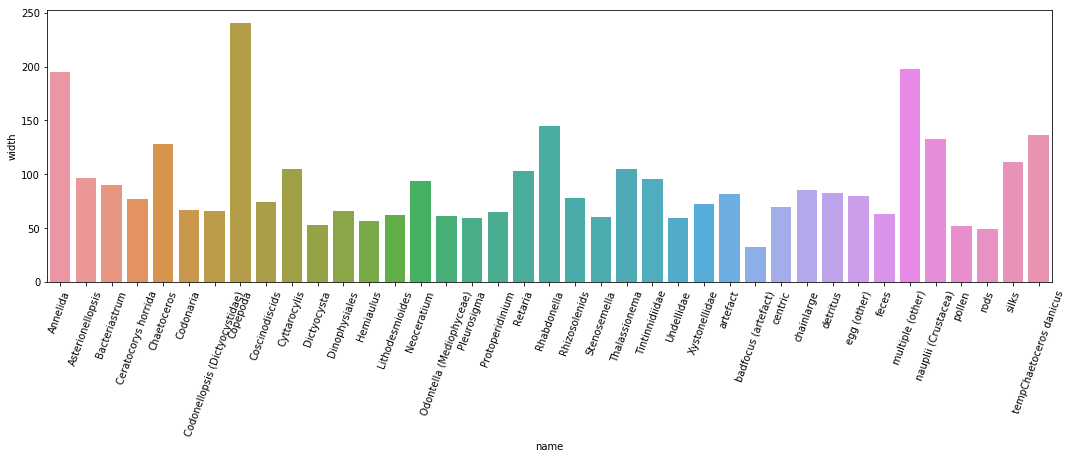

In [84]:
fig, ax = pyplot.subplots(figsize=stnd_dim)

g = sns.barplot(x=df.index, y=df_dimensions.width)
plt.xticks(rotation=70);

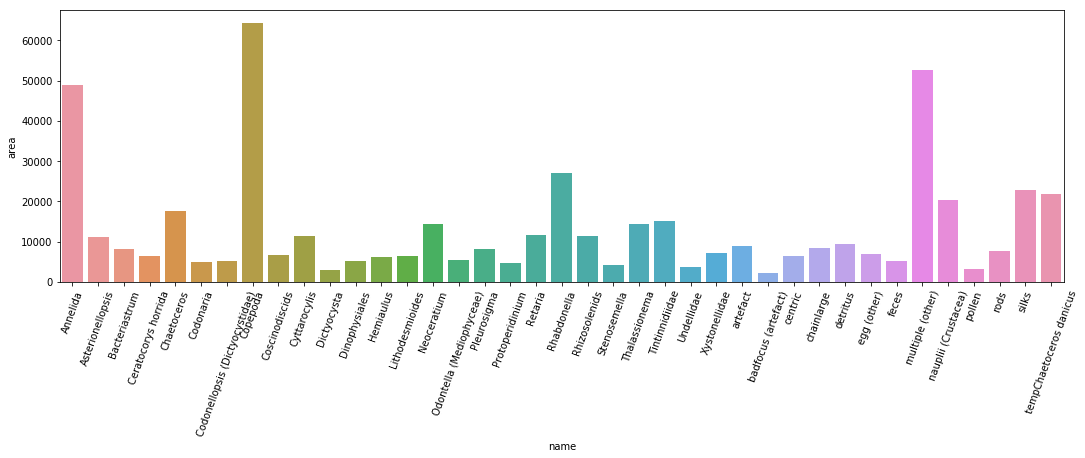

In [85]:
fig, ax = pyplot.subplots(figsize=stnd_dim)

g = sns.barplot(x=df.index, y=df_dimensions.area)
plt.xticks(rotation=70);

The graph below shows instead the **standard deviation** of the areas of images of each class. The interesting thing to notice is that some species show a very low std, this means that hypotetically some specie have an images whose dimensions range across a tight interval.

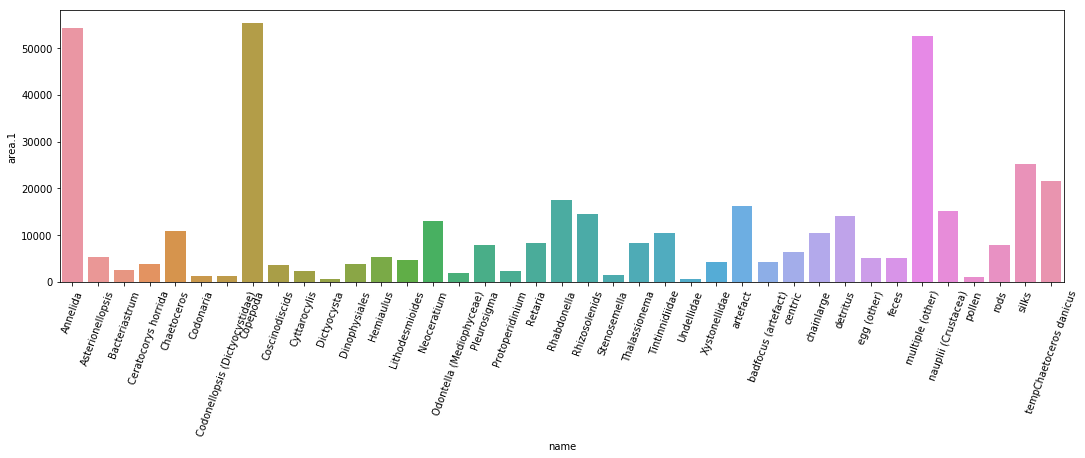

In [86]:
fig, ax = pyplot.subplots(figsize=stnd_dim)

g = sns.barplot(x=df.index, y=df_dimensions['area.1'])
plt.xticks(rotation=70);

### Comments on the image dimensions analysis
This analysis shows that that the majority of the images have both width and height around 50 pixel. Nevertheless, medians and means of both are above this value. Moreover, the **median** of the area is 5776 which diverges from the the **mean** value which is 11536. In fact, is possible to notice a relatively high value of standard devation.

We chose to reformat each image to **64x64** since we believe it is a good tradeoff to follow the distribution of high, width and area to the images. The resizing is not perfomed statically as the dataset would occupy too much space. We mantain the aspect ratio for all the images, inserting white bars to complete the square shape.

Moreover, since the statics above show interessing correlations between size and class, we decided keep these information in order to exploit potiential correlations in the final model.

## 3. Model Selection

### Classification strategies
To tackle the issue of an unbalanced dataset, we deploy two main stategies:
<ul>
    <li><i>weighted loss function</i>, which gives more importance to errors made on classes with a small cardinality.</li>
    <li><i>weighted sampler</i>, instead, samples image <b>uniformly</b> for each class. It means that for each minibatch there will be an equal amount of classes.</li>
</ul> 

In [16]:
# Generating weights to be applied to the loss function
def weight_gen(x):
    x['count'] =  (1./100) * len(plankton_df) / int(x['count'])
    return x

pand_dict = count_per_class.apply(weight_gen, axis=1).to_dict()
mapper = []

for i, k in enumerate(pand_dict['level2'].items()):
    mapper.append((k[1], pand_dict['count'][k[0]]))

mapper = sorted(mapper, key=lambda x: x[1])

d_mapping = {}
for i, val in enumerate(mapper):
    d_mapping[val[0]] = (i, val[1])

As targets are represented as strings, we found useful to map these labels to an integer value.

In [17]:
# generic mapping
distinct_plankton_labels = set(plankton_df['level2'].unique())
label_mapping = { e:d_mapping[e][0] for e in distinct_plankton_labels }

In [18]:
# mapping without considering 'detritus'
distinct_plankton_labels.remove('detritus')
no_detritus_label_mapping = { e:d_mapping[e][0] - 1 for e in distinct_plankton_labels}

To choose among different models and hyperparameters we use Stratified K-Fold validation.<br>
The stratified version of this algorithm allows to have in each fold the same class distributions as in the original dataset.

## Bulding the model
We address the plankton classification using several *CNNs*. Nevertheless, since as we stated before the image dimensions and the plankton class seem to be correlated someway, we inject the sizes of images as addictional input into the the fully connected layer. This technique is alled *feature injection of handcrafted features*, further information can be found here [1]. Since our shape analysis shows that width heigth and area range across large intervals, we chose to inject the ***log*** of those values, divided by the value of the log of the maximum value for that dimension, to smooth the differences among different values.

Tests have shown that our model indeed achives higher accuracy if we inject such additional informations. We have therefore also considered the opportunity of injecting the handcrafted features present in the 'native_features' file, however we chose to go for the development of a fully autonomous system, avoiding the cost of manual preprocessing. However, domain knowledge could help in selecting few features cost-effective to manually process and able to improve the accuracy further if injected. 

Regarding the CNN, we have tested different architectures, both narrow and large, following also two different strategies: hierarchical classification (separating detritus and non-detritus first, then classifying the non-detritus) and overall classification (everything in one step). We show the results of some of them below.

In [27]:
# Hierarchical Classifiers
# Classify the image telling wheter the label of the image is detritus or not.
class DetritusModel(nn.Module):
    def __init__(self, injection_dim=3):
        self.inj_d = injection_dim 
        super(DetritusModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=5)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=5)
        self.conv3 = nn.Conv2d(16, 20, kernel_size=5)
        
        self.fc1 = nn.Linear(20*9*9 + injection_dim, 700)
        self.fc2 = nn.Linear(700, 300)
        self.fc3 = nn.Linear(300, 40)
        self.fc4 = nn.Linear(40, 2)

    def forward(self, image, inj_features):
        # Separate Injected features and Image
        x = image
        x_inject = inj_features
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(self.conv3(x))
        x = x.view(-1, 20*9*9)
        x = torch.cat((x, x_inject), 1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.dropout(x, training=self.training)
        x = F.log_softmax(self.fc4(x))
        return x

# Classification done on all the dataset except detritus images
class NonDetritusModel(nn.Module):
    def __init__(self, injection_dim=3):
        self.inj_d = injection_dim 
        super(NonDetritusModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=5)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=5)
        self.conv3 = nn.Conv2d(16, 20, kernel_size=5)
        
        self.fc1 = nn.Linear(20*9*9 + injection_dim, 700)
        self.fc2 = nn.Linear(700, 300)
        self.fc3 = nn.Linear(300, 38)

    def forward(self, image, inj_features):
        # Separate Injected features and Image
        x = image
        x_inject = inj_features
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(self.conv3(x))
        x = x.view(-1, 20*9*9)
        x = torch.cat((x, x_inject), 1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x))
        return x

In [28]:
# Overall model
class PlanktonModel(nn.Module):
    def __init__(self, injection_dim=3):
        self.inj_d = injection_dim 
        super(PlanktonModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=5)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=5)
        self.conv3 = nn.Conv2d(16, 20, kernel_size=5)
        
        self.fc1 = nn.Linear(20*9*9 + injection_dim, 700)
        self.fc2 = nn.Linear(700, 300)
        self.fc3 = nn.Linear(300, 39)

    def forward(self, image, inj_features):
        # Separate Injected features and Image
        x = image
        x_inject = inj_features
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(self.conv3(x))
        x = x.view(-1, 20*9*9)
        x = torch.cat((x, x_inject), 1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, training=self.training)
        x = F.log_softmax(self.fc3(x))
        return x

In [29]:
# Overall Model, smaller
class PlanktonsSmallModel(nn.Module):
    def __init__(self, injection_dim=3):
        self.inj_d = injection_dim 
        super(PlanktonsSmallModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 12, kernel_size=5)
        self.conv3 = nn.Conv2d(12, 16, kernel_size=5)
        
        self.fc1 = nn.Linear(16*9*9 + injection_dim, 400)
        self.fc2 = nn.Linear(400, 200)
        self.fc3 = nn.Linear(200, 39)

    def forward(self, image, inj_features):
        # Separate Injected features and Image
        x = image
        x_inject = inj_features
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(self.conv3(x))
        x = x.view(-1, 16*9*9)
        x = torch.cat((x, x_inject), 1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, training=self.training)
        x = F.log_softmax(self.fc3(x))
        return x

The *PlanktonDataset* class is a implementation of the *Dataset* class of PyTorch. Our customized version allows to **inject** the shape of image as a feature. 

In [30]:
class PlanktonDataset(Dataset):
    """Plankton dataset."""

    def __init__(self, X, y, img_files, label_mapping=None, transform=None, single_output=False):
        """
        Args:
            X, y: inputs, targets as np array
            img_files: Dictionary of images
            label_mapping: Dictionary which defines how to map label from string to int
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        
        self.inputs = X
        self.targets = y
        self.img_files = img_files
        self.label_mapping = label_mapping
        self.transform = transform
        self.single_output = single_output

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        if isinstance(idx, torch.Tensor):
            idx = idx.item()
        img_name = 'imgs/' + str(self.inputs[idx]) + '.jpg'
        image = Image.open(self.img_files[img_name])
        
        label = self.targets[idx]
        
        # map target into an int
        if self.label_mapping != None:
            target = self.label_mapping[label]
            
        # we use MSELoss to compute error on a single output and this loss function requires a tensor of type float
        if self.single_output:
            label = torch.tensor([target], dtype=torch.float32)
        else:
            label = torch.tensor(target, dtype=torch.long)
        
        # feature injection (real size of the image before transformation)
        real_w, real_h = image.size
        # 6.6 is the log of max_height, 6.88 is the log ....
        log_values = [log(real_w) / 6.6, log(real_h) / 6.88, log(real_w * real_h) / 13.28]

        if self.transform:
            image = self.transform(image)

        sample = {'image': image, 'inj_features': torch.tensor(log_values, dtype=torch.float), 'label': label, 'objid' : self.inputs[idx]}
        return sample

We split the dataframe in training set and validation set, **maintaining** the distribution of classes in both dataset. Since the class the class are quite unbalanced, this approach improves consistently the efficency of the model.

In [23]:
X_ = plankton_df['objid']
y_ = plankton_df['level2']

X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.15, stratify=y_)

The class distribution are checked and displayed.

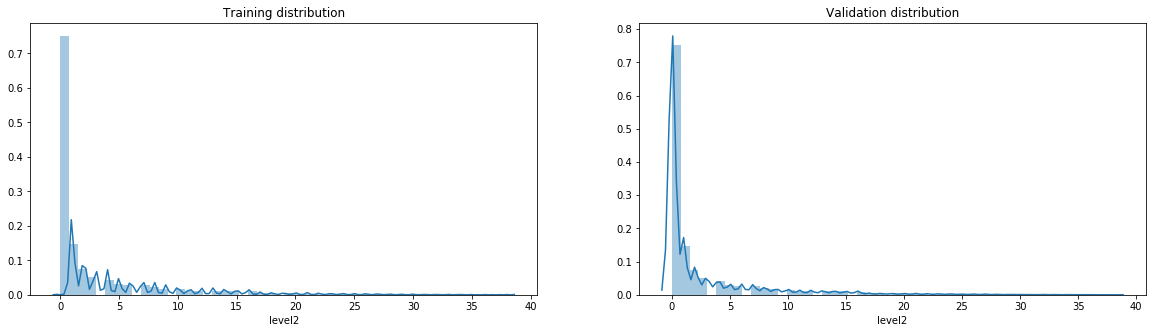

In [23]:
# Check distribution of classes in both train and validation sets
fig, ax = plt.subplots(ncols=2, figsize=(20, 5))
sns.distplot(y_train.map(label_mapping), ax=ax[0])
sns.distplot(y_test.map(label_mapping), ax=ax[1])
ax[0].set_title('Training distribution')
ax[1].set_title('Validation distribution')
plt.show()

The DataLoader is a PyTorch auxiliary class that allows to forward the batches to the model. As we saw before, the dataset labels are quite unbalanced, so the dataloader follows essentially two criterias:
- Transform randomly the images, with a probability of 0.5 both to be flipped orizontally, vertically or rotated. Conseguently the data loader will generate 8 potential images for each sample
- Weight the selection of samples for each class.

We would like to have a good score on the **average accuracy per class**. So the idea is that we want to minimize the F score. Because the model should be good to recognize every class.

##### Funny fact
It would be possible to achieve 65% accuracy with a model stating simply *it is a detritus*.

##### Transformations

In [31]:
# Tranformations
# transformations to apply to training set
training_transformations = transforms.Compose([
                                               ResizeSquare(64),
                                               transforms.RandomHorizontalFlip(),
                                               transforms.RandomVerticalFlip(),
                                                transforms.RandomRotation([-90, +90]),
                                               ToTensor()
                                           ])

# transformations to apply to test/validation set
test_transformations = transforms.Compose([
                                   ResizeSquare(64),
                                   ToTensor()
                                ])

In [25]:
skf = StratifiedKFold(n_splits=10)

In [26]:
k_fold_split = skf.split(X_train, y_train)

### Overall classification

#### Overall classification - 'PlanktonModel' with Weighted Sampler

As stated before, we draw each sample with a probability depending on its class. This probability is computed upon weights, defined as the cardinality of the entire dataset divided by the number of samples in the specific class. This means that, as the class gets less items, the probability of drawing its samples grows.

In [40]:
train_idx, val_idx = next(k_fold_split)

# weights for weighted random sampler
# weights_df = plankton_df[plankton_df['objid'].isin(X_train.values[train_idx])] # assign weights only to samples in the training set
weights_df = pd.DataFrame({'objid':X_train.values[train_idx], 'level2': y_train.values[train_idx]})
weights_df['level2'] = weights_df['level2'].map(label_mapping)
weights_df['count'] = weights_df.groupby('level2')['level2'].transform('count')
weights_df['count'] = len(weights_df) / weights_df['count']
weights = weights_df['count'].values
weights = torch.DoubleTensor(weights)
detritus_wrs = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))

plank_train_dataset = PlanktonDataset(X_train.values[train_idx], y_train.values[train_idx],
                                        img_files = img_files,
                                        label_mapping = label_mapping,
                                        transform = training_transformations,
                                        )
plank_train_dataloader = DataLoader(plank_train_dataset, batch_size=128, sampler=detritus_wrs, num_workers=4)

plank_val_dataset = PlanktonDataset(X_train.values[val_idx], y_train.values[val_idx],
                                        img_files = img_files,
                                        label_mapping = label_mapping,
                                        transform = test_transformations,
                                        )
plank_val_dataloader = DataLoader(plank_val_dataset, batch_size=128, num_workers=4)

In [ ]:
### Training of the model with weighted sampler

plank_model = PlanktonModel().to(device)
plank_model.zero_grad()
plank_model.train()

loss_function = nn.NLLLoss()

# Confusions matrix analysis
n_classes = 39

optimizer = torch.optim.Adam(plank_model.parameters())

test_loss_values = []
train_loss_values = []

epoch = 15

for e in range(epoch):
    # training
    avg_loss = train_model(plank_train_dataloader, plank_model, optimizer, loss_function)

    correct, confusion_matrix, accuracies, avg_loss_test = test_model(plank_val_dataloader, plank_model, loss_function, n_classes)
    mean_accuracy = np.mean(accuracies)
    accuracy = correct / len(val_idx)
    
    print("Epoch {0}. Accuracy: {1}. Mean Accuracy: {2}. Avg Loss train: {3}. Avg Loss test: {4}".format(e + 1, round(accuracy, 4), mean_accuracy, avg_loss, avg_loss_test))
    test_loss_values.append(avg_loss_test)
    train_loss_values.append(avg_loss)
    
    
df = pd.DataFrame({'x': range(1, epoch + 1), 'train': train_loss_values, 'test': test_loss_values})
for column in df.drop('x', axis=1):
    plt.plot(df['x'], df[column], label=column)

plt.show()

#### Overall classification - 'SmallPlanktonModel' with Weighted Sampler

This is a smaller, reduced, model: bigger models have higher classification power, but are more computationally expensive and prone to overfitting. Therefore, whenever possible, a simpler model should be preferred.

In [28]:
train_idx, val_idx = next(k_fold_split)

#
weights_df = pd.DataFrame({'objid':X_train.values[train_idx], 'level2': y_train.values[train_idx]})
weights_df['level2'] = weights_df['level2'].map(label_mapping)
weights_df['count'] = weights_df.groupby('level2')['level2'].transform('count')
weights_df['count'] = len(weights_df) / weights_df['count']
weights = weights_df['count'].values
weights = torch.DoubleTensor(weights)
detritus_wrs = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))
#

plank_sm_train_dataset = PlanktonDataset(X_train.values[train_idx], y_train.values[train_idx],
                                        img_files = img_files,
                                        label_mapping = label_mapping,
                                        transform = training_transformations,
                                        )
plank_sm_train_dataloader = DataLoader(plank_sm_train_dataset, batch_size=128, sampler=detritus_wrs, num_workers=4)

plank_sm_val_dataset = PlanktonDataset(X_train.values[val_idx], y_train.values[val_idx],
                                        img_files = img_files,
                                        label_mapping = label_mapping,
                                        transform = test_transformations,
                                        )
plank_sm_val_dataloader = DataLoader(plank_sm_val_dataset, batch_size=128, num_workers=4)

In [35]:
### Training of the model with weighted sampler

plank_sm_model = PlanktonsSmallModel().to(device)
plank_sm_model.zero_grad()
plank_sm_model.train()

loss_function = nn.NLLLoss()

# Confusions matrix analysis
n_classes = 39

optimizer = torch.optim.Adam(plank_sm_model.parameters())

test_loss_values = []
train_loss_values = []

epoch = 15

for e in range(epoch):
    # training
    avg_loss = train_model(plank_sm_train_dataloader, plank_sm_model, optimizer, loss_function)

    correct, confusion_matrix, accuracies, avg_loss_test = test_model(plank_sm_val_dataloader, plank_sm_model, loss_function, n_classes)
    mean_accuracy = np.mean(accuracies)
    accuracy = correct / len(val_idx)
    
    print("Epoch {0}. Accuracy: {1}. Mean Accuracy: {2}. Avg Loss train: {3}. Avg Loss test: {4}".format(e + 1, round(accuracy, 4), mean_accuracy, avg_loss, avg_loss_test))
    test_loss_values.append(avg_loss_test)
    train_loss_values.append(avg_loss)

1450it [02:41,  9.00it/s]
162it [00:05, 27.36it/s]

Epoch 1. Accuracy: 0.6676. Mean Accuracy: 9.47894815296881. Avg Loss train: 1.2986705993783885. Avg Loss test: 1.1713964519677338



1450it [02:39,  9.07it/s]
162it [00:05, 27.05it/s]

Epoch 2. Accuracy: 0.6868. Mean Accuracy: 12.171341468325595. Avg Loss train: 1.0395303493121575. Avg Loss test: 1.094032359711918



1450it [02:38,  9.16it/s]
162it [00:06, 26.69it/s]

Epoch 3. Accuracy: 0.7134. Mean Accuracy: 16.825554538972373. Avg Loss train: 0.9385227339843224. Avg Loss test: 0.9917627716505969



1450it [02:41,  9.19it/s]
162it [00:07, 22.31it/s]

Epoch 4. Accuracy: 0.723. Mean Accuracy: 17.798958172773894. Avg Loss train: 0.8672228201915478. Avg Loss test: 0.9402359731403398



1450it [02:38,  9.14it/s]
162it [00:06, 26.65it/s]

Epoch 5. Accuracy: 0.7323. Mean Accuracy: 18.57218973552526. Avg Loss train: 0.8210183883124385. Avg Loss test: 0.9138955146442225



1450it [02:40,  9.02it/s]
162it [00:07, 22.50it/s]

Epoch 6. Accuracy: 0.739. Mean Accuracy: 19.033984067161917. Avg Loss train: 0.7932467750845285. Avg Loss test: 0.8908588908336781



1450it [02:40,  9.04it/s]
162it [00:06, 26.78it/s]

Epoch 7. Accuracy: 0.7459. Mean Accuracy: 21.00097147271517. Avg Loss train: 0.763611080399875. Avg Loss test: 0.8529425200856762



1450it [02:42,  8.94it/s]
162it [00:06, 24.61it/s]

Epoch 8. Accuracy: 0.7434. Mean Accuracy: 21.299415976834. Avg Loss train: 0.7490888763912793. Avg Loss test: 0.8498957127700617



1450it [02:38,  9.14it/s]
162it [00:06, 26.51it/s]

Epoch 9. Accuracy: 0.7446. Mean Accuracy: 22.601972656216574. Avg Loss train: 0.7310076013515735. Avg Loss test: 0.8470678520791325



1450it [02:40,  9.02it/s]
162it [00:06, 23.37it/s]

Epoch 10. Accuracy: 0.743. Mean Accuracy: 22.346833237133087. Avg Loss train: 0.7266201605467961. Avg Loss test: 0.854882624414232



1450it [02:36,  9.24it/s]
162it [00:06, 25.37it/s]

Epoch 11. Accuracy: 0.7433. Mean Accuracy: 20.757246466152885. Avg Loss train: 0.716705159051665. Avg Loss test: 0.8643676520865641



1450it [02:39,  9.12it/s]
162it [00:06, 23.93it/s]

Epoch 12. Accuracy: 0.7576. Mean Accuracy: 22.453313775404897. Avg Loss train: 0.7047527396062325. Avg Loss test: 0.8127363469497657



1450it [02:39,  9.51it/s]
162it [00:06, 25.15it/s]


Epoch 13. Accuracy: 0.752. Mean Accuracy: 24.144562871434218. Avg Loss train: 0.6919907714375134. Avg Loss test: 0.8209265426353172


1450it [02:39,  9.10it/s]
162it [00:06, 23.40it/s]

Epoch 14. Accuracy: 0.7555. Mean Accuracy: 24.994932466085636. Avg Loss train: 0.6940021413564682. Avg Loss test: 0.8244657531196689



1450it [02:39,  9.08it/s]
162it [00:06, 25.41it/s]

Epoch 15. Accuracy: 0.7636. Mean Accuracy: 24.26106255206418. Avg Loss train: 0.6840909641158992. Avg Loss test: 0.802736430256455


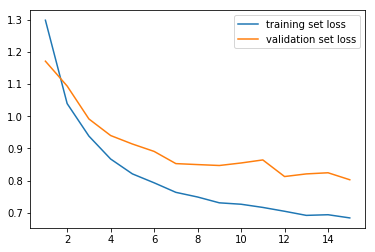

In [37]:
# plot accuracy graph
plt.figure()
plt.plot(range(1, epoch+1), train_loss_values, label='training set loss')
plt.plot(range(1, epoch+1), test_loss_values, label='validation set loss')
plt.legend()
plt.show()

#### Overall classification - 'PlanktonModel' with Weighted Loss

We deploy here the second strategy, that is weighting the loss to make errors on classes with less cardinality more penalized than errors on populated classes.

In [51]:
# define weigths for each class
weights = torch.from_numpy(np.array(list(sorted(map(lambda x: x[1], d_mapping.values()))))).type(torch.FloatTensor).to(device)

In [31]:
train_idx, val_idx = next(k_fold_split)

plank_wl_train_dataloader, plank_wl_val_dataloader = get_data_loaders(X_train, y_train, train_idx, val_idx, mapping=label_mapping, 
                                                                      train_transformations=training_transformations, test_transformations=test_transformations)

1450it [01:03, 22.68it/s]
162it [00:06, 25.02it/s]

Epoch 1. Accuracy: 0.0687. Mean Accuracy: 15.411389050924354. Avg Loss train: 2.930597141364525. Avg Loss test: 2.6770842678752946



1450it [01:00, 24.04it/s]
162it [00:06, 23.87it/s]


Epoch 2. Accuracy: 0.1258. Mean Accuracy: 20.023510429898543. Avg Loss train: 2.6630296495043. Avg Loss test: 2.5439551244547336


1450it [00:53, 27.08it/s]
162it [00:07, 21.78it/s]

Epoch 3. Accuracy: 0.1488. Mean Accuracy: 22.799121145163173. Avg Loss train: 2.5013460256313453. Avg Loss test: 2.4200420519452037



1450it [00:59, 24.56it/s]
162it [00:07, 21.99it/s]

Epoch 4. Accuracy: 0.1933. Mean Accuracy: 26.231829037162576. Avg Loss train: 2.3565827989578247. Avg Loss test: 2.262450245427497



1450it [01:02, 23.37it/s]
162it [00:07, 22.81it/s]

Epoch 5. Accuracy: 0.2409. Mean Accuracy: 28.46273236227288. Avg Loss train: 2.259038697522262. Avg Loss test: 2.2750753708827642



1450it [00:56, 25.61it/s]
162it [00:06, 25.61it/s]

Epoch 6. Accuracy: 0.2207. Mean Accuracy: 31.16579723619722. Avg Loss train: 2.1738999773716103. Avg Loss test: 2.159844015115573



1450it [00:59, 24.17it/s]
162it [00:06, 24.24it/s]

Epoch 7. Accuracy: 0.2925. Mean Accuracy: 35.667373310787085. Avg Loss train: 2.128808569579289. Avg Loss test: 2.0700516115736076



1450it [01:02, 23.03it/s]
162it [00:06, 24.95it/s]

Epoch 8. Accuracy: 0.2483. Mean Accuracy: 37.08379921245906. Avg Loss train: 2.056339982706925. Avg Loss test: 2.038044989476969



1450it [00:59, 26.67it/s]
162it [00:06, 23.15it/s]

Epoch 9. Accuracy: 0.252. Mean Accuracy: 34.95775686607507. Avg Loss train: 2.0138381248918074. Avg Loss test: 2.063574133095918



1450it [01:07, 22.74it/s]
162it [00:07, 21.04it/s]

Epoch 10. Accuracy: 0.2428. Mean Accuracy: 35.22834122209375. Avg Loss train: 1.9705690593349523. Avg Loss test: 1.977836260089168



1450it [00:56, 25.61it/s]
162it [00:07, 22.32it/s]

Epoch 11. Accuracy: 0.2705. Mean Accuracy: 38.45197698890212. Avg Loss train: 1.8942229925558485. Avg Loss test: 1.9247153772984023



1450it [00:57, 22.14it/s]
162it [00:07, 22.65it/s]

Epoch 12. Accuracy: 0.2873. Mean Accuracy: 38.614912414502875. Avg Loss train: 1.9422329494254342. Avg Loss test: 1.9449094533920288



1450it [01:03, 23.10it/s]
162it [00:07, 22.63it/s]

Epoch 13. Accuracy: 0.3227. Mean Accuracy: 40.877675588904864. Avg Loss train: 1.8641253298932108. Avg Loss test: 1.8631166734813172



1450it [01:00, 23.95it/s]
162it [00:07, 23.11it/s]

Epoch 14. Accuracy: 0.3285. Mean Accuracy: 40.680441732096675. Avg Loss train: 1.8383191354932455. Avg Loss test: 1.906493024325665



1450it [01:04, 23.10it/s]
162it [00:07, 22.64it/s]


Epoch 15. Accuracy: 0.307. Mean Accuracy: 41.475859133553485. Avg Loss train: 1.8200725506914073. Avg Loss test: 1.8653091170169689


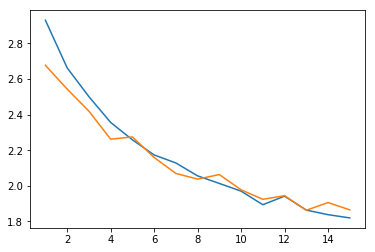

In [52]:
plank_wl_model = PlanktonModel().to(device)
plank_wl_model.zero_grad()
plank_wl_model.train()

loss_function = nn.NLLLoss(weight=weights)

# Confusions matrix analysis
n_classes = 39

optimizer = torch.optim.Adam(plank_wl_model.parameters())

test_loss_values = []
train_loss_values = []

epoch = 15

for e in range(epoch):
    # training
    avg_loss = train_model(plank_wl_train_dataloader, plank_wl_model, optimizer, loss_function)

    correct, confusion_matrix, accuracies, avg_loss_test = test_model(plank_wl_val_dataloader, plank_wl_model, loss_function, n_classes)
    mean_accuracy = np.mean(accuracies)
    accuracy = correct / len(val_idx)
    
    print("Epoch {0}. Accuracy: {1}. Mean Accuracy: {2}. Avg Loss train: {3}. Avg Loss test: {4}".format(e + 1, round(accuracy, 4), mean_accuracy, avg_loss, avg_loss_test))
    test_loss_values.append(avg_loss_test)
    train_loss_values.append(avg_loss)
    
# plot accuracy graph
plt.figure()
plt.plot(range(1, epoch+1), train_loss_values, label='training set loss')
plt.plot(range(1, epoch+1), test_loss_values, label='validation set loss')
plt.legend()
plt.show()

#### Overall classification - 'SmallPlanktonModel' with Weighted Loss

In [53]:
train_idx, val_idx = next(k_fold_split)

plank_wlsm_train_dataloader, plank_wlsm_val_dataloader = get_data_loaders(X_train, y_train, train_idx, val_idx, mapping=label_mapping, 
                                                                      train_transformations=training_transformations, test_transformations=test_transformations)

1450it [01:04, 22.56it/s]
162it [00:07, 21.88it/s]

Epoch 1. Accuracy: 0.1177. Mean Accuracy: 17.030118647542096. Avg Loss train: 2.9189953964332056. Avg Loss test: 2.6191365166946694



1450it [01:04, 27.50it/s]
162it [00:07, 22.78it/s]

Epoch 2. Accuracy: 0.1589. Mean Accuracy: 20.07477117648936. Avg Loss train: 2.5791060464957667. Avg Loss test: 2.460369026219403



1450it [01:07, 21.63it/s]
162it [00:06, 24.05it/s]

Epoch 3. Accuracy: 0.1272. Mean Accuracy: 23.36156033853326. Avg Loss train: 2.4657840379353226. Avg Loss test: 2.3918713522546087



1450it [00:58, 24.68it/s]
162it [00:06, 23.86it/s]

Epoch 4. Accuracy: 0.1536. Mean Accuracy: 25.43180481289035. Avg Loss train: 2.3607620088807466. Avg Loss test: 2.3132827907432745



1450it [00:56, 25.62it/s]
162it [00:07, 22.91it/s]

Epoch 5. Accuracy: 0.1767. Mean Accuracy: 28.600912341400317. Avg Loss train: 2.287891644938239. Avg Loss test: 2.1909993798644454



1450it [01:01, 23.56it/s]
162it [00:07, 20.99it/s]

Epoch 6. Accuracy: 0.2034. Mean Accuracy: 31.279251049561115. Avg Loss train: 2.263007428728301. Avg Loss test: 2.134574302184729



1450it [01:06, 21.74it/s]
162it [00:07, 21.64it/s]

Epoch 7. Accuracy: 0.239. Mean Accuracy: 31.037282741909728. Avg Loss train: 2.175369913660247. Avg Loss test: 2.1352205364792436



1450it [01:05, 21.99it/s]
162it [00:07, 22.70it/s]

Epoch 8. Accuracy: 0.2405. Mean Accuracy: 30.80627743619492. Avg Loss train: 2.1553163294545534. Avg Loss test: 2.163227536060192



1450it [01:00, 23.78it/s]
162it [00:06, 28.36it/s]

Epoch 9. Accuracy: 0.2543. Mean Accuracy: 33.87297593773675. Avg Loss train: 2.120425495197033. Avg Loss test: 2.0727504896528925



1450it [01:01, 23.63it/s]
162it [00:06, 23.77it/s]

Epoch 10. Accuracy: 0.2549. Mean Accuracy: 37.42392132410274. Avg Loss train: 2.066204657842373. Avg Loss test: 2.020434884377468



1450it [01:01, 23.57it/s]
162it [00:07, 23.06it/s]

Epoch 11. Accuracy: 0.2463. Mean Accuracy: 33.81600314249213. Avg Loss train: 2.057286521607432. Avg Loss test: 2.031264886076068



1450it [01:01, 27.02it/s]
162it [00:06, 24.61it/s]

Epoch 12. Accuracy: 0.251. Mean Accuracy: 32.022640117026135. Avg Loss train: 2.0127561116629633. Avg Loss test: 2.20521374249164



1450it [00:58, 30.62it/s]
162it [00:06, 24.57it/s]

Epoch 13. Accuracy: 0.2958. Mean Accuracy: 38.64429746509348. Avg Loss train: 1.990968754579281. Avg Loss test: 1.9511456489562988



1450it [00:56, 25.58it/s]
162it [00:06, 26.26it/s]

Epoch 14. Accuracy: 0.2706. Mean Accuracy: 39.148773204730674. Avg Loss train: 1.9262647452436645. Avg Loss test: 1.9262008953977514



1450it [00:58, 29.17it/s]
162it [00:06, 24.13it/s]


Epoch 15. Accuracy: 0.3088. Mean Accuracy: 40.033341549234045. Avg Loss train: 1.9590095732335386. Avg Loss test: 1.8504290830941847


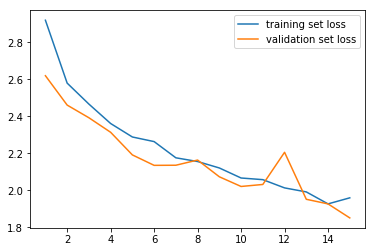

In [54]:
plank_wlsm_model = PlanktonModel().to(device)
plank_wlsm_model.zero_grad()
plank_wlsm_model.train()

loss_function = nn.NLLLoss(weights)

# Confusions matrix analysis
n_classes = 39

optimizer = torch.optim.Adam(plank_wlsm_model.parameters())

test_loss_values = []
train_loss_values = []

epoch = 15

for e in range(epoch):
    # training
    avg_loss = train_model(plank_wlsm_train_dataloader, plank_wlsm_model, optimizer, loss_function)

    correct, confusion_matrix, accuracies, avg_loss_test = test_model(plank_wlsm_val_dataloader, plank_wlsm_model, loss_function, n_classes)
    mean_accuracy = np.mean(accuracies)
    accuracy = correct / len(val_idx)
    
    print("Epoch {0}. Accuracy: {1}. Mean Accuracy: {2}. Avg Loss train: {3}. Avg Loss test: {4}".format(e + 1, round(accuracy, 4), mean_accuracy, avg_loss, avg_loss_test))
    test_loss_values.append(avg_loss_test)
    train_loss_values.append(avg_loss)
    
# plot accuracy graph
plt.figure()
plt.plot(range(1, epoch+1), train_loss_values, label='training set loss')
plt.plot(range(1, epoch+1), test_loss_values, label='validation set loss')
plt.legend()
plt.show()

### Hierarchical Classification
We test here classification in two steps, separating first between detritus and non detritus, and then classifying the non detritus according the other different classes.
#### Detritus Model
We aim to tell apart detritus vs non detritus using the weighted sampling strategy.

In [24]:
# map all labels to 1 and detritus to 0
detritus_mapping = {e:1 for e in distinct_plankton_labels}
detritus_mapping['detritus'] = 0

In [62]:
train_idx, val_idx = next(k_fold_split)

# weights for weighted random sampler
weights_df = plankton_df[plankton_df['objid'].isin(X_train.values[train_idx])] # assign weights only to samples in the training set
weights_df['level2'] = weights_df['level2'].map(detritus_mapping)
weights_df['count'] = weights_df.groupby('level2')['level2'].transform('count')
weights_df['count'] = len(weights_df) / weights_df['count']
weights = weights_df['count'].values
weights = torch.DoubleTensor(weights)
detritus_wrs = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))

detritus_train_dataloader, detritus_val_dataloader = get_data_loaders(X_train, y_train, train_idx, val_idx, mapping=detritus_mapping, 
                                                                      train_transformations=training_transformations, test_transformations=test_transformations,
                                                                      sampler=detritus_wrs)

1450it [02:30,  9.63it/s]
162it [00:07, 22.20it/s]

Epoch 1. Accuracy: 0.7881. Mean Accuracy: 78.29339848430936. Avg Loss train: 0.496200006439768. Avg Loss test: 0.4625215212136139



1450it [02:19, 10.36it/s]
162it [00:06, 25.59it/s]

Epoch 2. Accuracy: 0.8032. Mean Accuracy: 79.86445151038893. Avg Loss train: 0.4454779263817031. Avg Loss test: 0.42194201162567846



1450it [02:13, 10.90it/s]
162it [00:06, 23.36it/s]

Epoch 3. Accuracy: 0.8119. Mean Accuracy: 80.76762700947552. Avg Loss train: 0.42796714001688463. Avg Loss test: 0.41144634746474984



1450it [02:13, 10.83it/s]
162it [00:06, 24.43it/s]

Epoch 4. Accuracy: 0.8027. Mean Accuracy: 80.66640296064058. Avg Loss train: 0.416008426074324. Avg Loss test: 0.4313746471831828



1450it [02:10, 11.07it/s]
162it [00:05, 27.48it/s]

Epoch 5. Accuracy: 0.8146. Mean Accuracy: 80.69660535100644. Avg Loss train: 0.40568822990203723. Avg Loss test: 0.3987670005471618



1450it [02:10, 11.10it/s]
162it [00:05, 27.36it/s]

Epoch 6. Accuracy: 0.816. Mean Accuracy: 81.84125131363896. Avg Loss train: 0.3992231759737278. Avg Loss test: 0.40034806728363037



1450it [02:12, 11.85it/s]
162it [00:06, 25.31it/s]

Epoch 7. Accuracy: 0.8127. Mean Accuracy: 81.6409768181812. Avg Loss train: 0.3945548669120361. Avg Loss test: 0.4007429326022113



1450it [02:10, 11.07it/s]
162it [00:06, 24.96it/s]

Epoch 8. Accuracy: 0.8219. Mean Accuracy: 82.47884225805998. Avg Loss train: 0.38661831557750703. Avg Loss test: 0.395040664591907



1450it [02:09, 11.19it/s]
162it [00:06, 26.54it/s]

Epoch 9. Accuracy: 0.8217. Mean Accuracy: 81.88836623436454. Avg Loss train: 0.3870269408616526. Avg Loss test: 0.3909267762928833



1450it [02:11,  9.97it/s]
162it [00:06, 24.57it/s]


Epoch 10. Accuracy: 0.8198. Mean Accuracy: 82.13395874832072. Avg Loss train: 0.3816856932331776. Avg Loss test: 0.39313721307265903


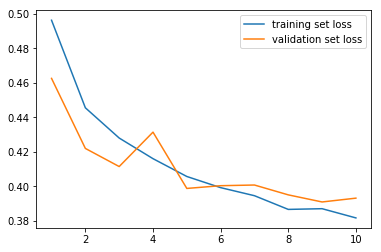

In [73]:
# first we train the model who classifies only detritus

detritus_model = DetritusModel().to(device)
detritus_model.zero_grad()
detritus_model.train()

loss_function = nn.NLLLoss()

# Confusions matrix analysis
n_classes = 2

optimizer = torch.optim.Adam(detritus_model.parameters())

test_loss_values = []
train_loss_values = []

epoch = 10

for e in range(epoch):
    # training
    avg_loss = train_model(detritus_train_dataloader, detritus_model, optimizer, loss_function)

    correct, confusion_matrix, accuracies, avg_loss_test = test_model(detritus_val_dataloader, detritus_model, loss_function, n_classes)
    mean_accuracy = np.mean(accuracies)
    accuracy = correct / len(val_idx)
    
    print("Epoch {0}. Accuracy: {1}. Mean Accuracy: {2}. Avg Loss train: {3}. Avg Loss test: {4}".format(e + 1, round(accuracy, 4), mean_accuracy, avg_loss, avg_loss_test))
    test_loss_values.append(avg_loss_test)
    train_loss_values.append(avg_loss)
    

# plot accuracy graph
plt.figure()
plt.plot(range(1, epoch+1), train_loss_values, label='training set loss')
plt.plot(range(1, epoch+1), test_loss_values, label='validation set loss')
plt.legend()
plt.show()

#### Non Detritus model
Again, we use the weighted sampling strategy, using the dataset without the samples of the detritus class.

In [74]:
# no_detritus model

X_no_d = no_detritus_df['objid']
y_no_d = no_detritus_df['level2']

X_nodet_train, X_nodet_val, y_nodet_train, y_nodet_val = train_test_split(X_no_d, y_no_d, test_size=0.20, stratify=y_no_d)

# weights for weighted random sampler
weights_df = no_detritus_df[no_detritus_df['objid'].isin(X_nodet_train.values)] # assign weights only to samples in the training set
weights_df['level2'] = weights_df['level2'].map(no_detritus_label_mapping)
weights_df['count'] = weights_df.groupby('level2')['level2'].transform('count')
weights_df['count'] = len(weights_df) / weights_df['count']
weights = weights_df['count'].values
weights = torch.DoubleTensor(weights)
no_detritus_wrs = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))

no_det_train_dataset = PlanktonDataset(X_nodet_train.values, y_nodet_train.values,
                                    img_files = img_files,
                                    label_mapping = no_detritus_label_mapping,
                                    transform = training_transformations
                                   )
no_det_train_dataloader = DataLoader(no_det_train_dataset, batch_size=128, sampler=no_detritus_wrs, num_workers=4)

no_det_val_dataset = PlanktonDataset(X_nodet_val.values, y_nodet_val.values,
                                    img_files = img_files,
                                    label_mapping = no_detritus_label_mapping,
                                    transform = test_transformations,
                                    )
no_det_val_dataloader = DataLoader(no_det_val_dataset, batch_size=128, num_workers=4)

652it [01:04, 10.13it/s]
163it [00:08, 19.66it/s]

Epoch 1. Accuracy: 0.5614. Mean Accuracy: 18.158267289181797. Avg Loss train: 1.6190941896906659. Avg Loss test: 1.4077661256848668



652it [01:02, 10.43it/s]
163it [00:07, 21.72it/s]

Epoch 2. Accuracy: 0.6238. Mean Accuracy: 25.047830910473348. Avg Loss train: 1.2479815915501191. Avg Loss test: 1.2159219581656662



652it [01:02, 10.50it/s]
163it [00:07, 21.45it/s]


Epoch 3. Accuracy: 0.675. Mean Accuracy: 28.980547261232545. Avg Loss train: 1.0807182871125227. Avg Loss test: 1.0520501725512779


652it [01:01, 10.60it/s]
163it [00:07, 28.62it/s]

Epoch 4. Accuracy: 0.6691. Mean Accuracy: 31.022387059352337. Avg Loss train: 0.9537310784031277. Avg Loss test: 1.0705016244408543



652it [01:00, 10.83it/s]
163it [00:07, 23.28it/s]

Epoch 5. Accuracy: 0.708. Mean Accuracy: 36.417740818263766. Avg Loss train: 0.8741785866534052. Avg Loss test: 0.9548217646914757



652it [00:59, 10.87it/s]
163it [00:07, 21.02it/s]

Epoch 6. Accuracy: 0.7151. Mean Accuracy: 37.454716972308226. Avg Loss train: 0.8160578035320972. Avg Loss test: 0.9408957649228031



652it [01:01, 10.58it/s]
163it [00:07, 21.72it/s]

Epoch 7. Accuracy: 0.7223. Mean Accuracy: 35.558958837244. Avg Loss train: 0.7786108366345152. Avg Loss test: 0.920938272052016



652it [01:01, 10.52it/s]
163it [00:06, 23.58it/s]

Epoch 8. Accuracy: 0.7531. Mean Accuracy: 41.248804407041995. Avg Loss train: 0.7316100028303504. Avg Loss test: 0.8081452349212273



652it [01:00, 10.73it/s]
163it [00:07, 22.33it/s]

Epoch 9. Accuracy: 0.7557. Mean Accuracy: 41.069925811016134. Avg Loss train: 0.7097962508720854. Avg Loss test: 0.7956378255153727



652it [01:03, 10.31it/s]
163it [00:06, 23.69it/s]


Epoch 10. Accuracy: 0.7562. Mean Accuracy: 42.21574165023442. Avg Loss train: 0.679901899507075. Avg Loss test: 0.8182369711940274


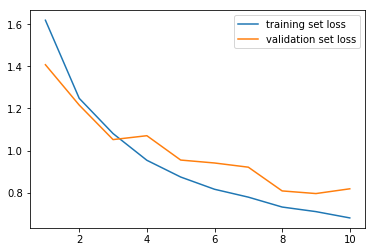

In [76]:
no_detritus_model = NonDetritusModel().to(device)
no_detritus_model.zero_grad()
no_detritus_model.train()

loss_function = nn.NLLLoss()

# Confusions matrix analysis
n_classes = 38

optimizer = torch.optim.Adam(no_detritus_model.parameters())

test_loss_values = []
train_loss_values = []

epoch = 10

for e in range(epoch):
    # training
    avg_loss = train_model(no_det_train_dataloader, no_detritus_model, optimizer, loss_function)

    correct, confusion_matrix, accuracies, avg_loss_test = test_model(no_det_val_dataloader, no_detritus_model, loss_function, n_classes)
    mean_accuracy = np.mean(accuracies)
    accuracy = correct / len(y_val)
    
    print("Epoch {0}. Accuracy: {1}. Mean Accuracy: {2}. Avg Loss train: {3}. Avg Loss test: {4}".format(e + 1, round(accuracy, 4), mean_accuracy, avg_loss, avg_loss_test))
    test_loss_values.append(avg_loss_test)
    train_loss_values.append(avg_loss)
    

# plot accuracy graph
plt.figure()
plt.plot(range(1, epoch+1), train_loss_values, label='training set loss')
plt.plot(range(1, epoch+1), test_loss_values, label='validation set loss')
plt.legend()
plt.show()

#### Putting everything together
What has been classified has non detritus by the first model is passed to the second one.

To compute the number of correct predictions, we count the number of samples correctly classified as detritus by the first model and the number of correctly classified samples by the second one.

In [152]:
# new dataloader with batch size = 1 to understand which sample is classified as non detritus

X_val_tog, y_val_tog = X_train.values[val_idx], y_train.values[val_idx]

det_tog_dataset = PlanktonDataset(X_val_tog, y_val_tog,
                                img_files=img_files, label_mapping=detritus_mapping,
                                 transform = test_transformations)

det_tog_dataloader = DataLoader(det_tog_dataset, batch_size=1, num_workers=4)

In [25]:
def get_f1_score_hierarchical(det_tog_dataloader, detritus_model, no_detritus_model):
    y_true = []
    y_pred = []

    for i, sample in tqdm(enumerate(det_tog_dataloader)):
        image = sample['image'].to(device)
        inj_features = sample['inj_features'].to(device)
        target = sample['label'].to(device)
        objid = sample['objid']

        row_image = plankton_df[plankton_df['objid']==objid]
        real_target = label_mapping[row_image['level2'].values[0]]

        output = detritus_model(image, inj_features)
        pred = output.max(1, keepdim=True)[1]

        y_true.append(real_target)

        if pred == 0:
            y_pred.append(0)
        else:
            output = no_detritus_model(image, inj_features)
            pred = output.max(1, keepdim=True)[1] + 1
            y_pred.append(pred)


    y_np_true = np.array(y_true)
    y_np_pred = np.array(y_pred)
    f1_w = f1_score(y_np_true, y_np_pred, average='weighted')
    f1_m = f1_score(y_np_true, y_np_pred, average='macro')
    return f1_w, f1_m

def get_f1_score(det_tog_dataloader, model):
    y_true = []
    y_pred = []

    for i, sample in tqdm(enumerate(det_tog_dataloader)):
        image = sample['image'].to(device)
        inj_features = sample['inj_features'].to(device)
        target = sample['label'].to(device)
        objid = sample['objid']

        row_image = plankton_df[plankton_df['objid']==objid]
        real_target = label_mapping[row_image['level2'].values[0]]

        output = model(image, inj_features)
        pred = output.max(1, keepdim=True)[1]

        y_true.append(real_target)
        y_pred.append(pred)

    y_np_true = np.array(y_true)
    y_np_pred = np.array(y_pred)
    f1_w = f1_score(y_np_true, y_np_pred, average='weighted')
    f1_m = f1_score(y_np_true, y_np_pred, average='macro')
    return f1_w, f1_m

#f1_w, f1_m = get_f1_score_hierarchical(det_tog_dataloader, detritus_model, no_detritus_model)

In [166]:
print('f1 weighted score:{0}. f1 macro score:{1}'.format(f1_w, f1_m))

f1 weighted score:0.7340312389583548. f1 macro score:0.3421474271026229


### Models backup

In [ ]:
torch.save(plank_model.state_dict(), './plank_model_15')
torch.save(plank_sm_model.state_dict(), './plank_sm_model_15')
torch.save(plank_wl_model.state_dict(), './plank_wl_model_15')
torch.save(plank_wlsm_model.state_dict(), './plank_wlsm_model_15')

#### **Model Testing** 

In [42]:
# no_detritus_model = NonDetritusModel().to(device)
# detritus_model = DetritusModel().to(device)

# no_detritus_model.load_state_dict(torch.load('./models/no_detritus_model_10'))
# detritus_model.load_state_dict(torch.load('./models/detritus_model_10'))

In [28]:
# weights for weighted random sampler
#weights_df = plankton_df[plankton_df['objid'].isin(X_train.values)] # assign weights only to samples in the training set
weights_df = pd.DataFrame({'objid':X_train.values, 'level2': y_train.values})
weights_df['level2'] = weights_df['level2'].map(detritus_mapping)
weights_df['count'] = weights_df.groupby('level2')['level2'].transform('count')
weights_df['count'] = len(weights_df) / weights_df['count']
weights = weights_df['count'].values
weights = torch.DoubleTensor(weights)
detritus_wrs = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))

final_det_train_dataset = PlanktonDataset(X_train.values, y_train.values,
                                        img_files = img_files,
                                        label_mapping = detritus_mapping,
                                        transform = training_transformations,
                                        )

final_det_train_dataloader = DataLoader(final_det_train_dataset, batch_size=128, sampler=detritus_wrs, num_workers=4)

final_det_val_dataset = PlanktonDataset(X_test.values, y_test.values,
                                        img_files = img_files,
                                        label_mapping = detritus_mapping,
                                        transform = test_transformations,
                                        )

final_det_val_dataloader = DataLoader(final_det_val_dataset, batch_size=128, num_workers=4)

In [29]:
# first we train the model who classifies only detritus

final_detritus_model = DetritusModel().to(device)
final_detritus_model.zero_grad()
final_detritus_model.train()

loss_function = nn.NLLLoss()

# Confusions matrix analysis
n_classes = 2

optimizer = torch.optim.Adam(final_detritus_model.parameters())

test_loss_values = []
train_loss_values = []

epoch = 4

for e in tqdm(range(epoch)):
    # training
    avg_loss = train_model(final_det_train_dataloader, final_detritus_model, optimizer, loss_function)

    correct, confusion_matrix, accuracies, avg_loss_test = test_model(final_det_val_dataloader, final_detritus_model, loss_function, n_classes)
    mean_accuracy = np.mean(accuracies)
    accuracy = correct / len(y_test)
    
    print("Epoch {0}. Accuracy: {1}. Mean Accuracy: {2}. Avg Loss train: {3}. Avg Loss test: {4}".format(e + 1, round(accuracy, 4), mean_accuracy, avg_loss, avg_loss_test))
    test_loss_values.append(avg_loss_test)
    train_loss_values.append(avg_loss)

# final_detritus_model.save(final_detritus.state_dict(), './final_detritus_30')

# plot accuracy graph
plt.figure()
plt.plot(range(1, epoch + 1), train_loss_values, label='training set loss')
plt.plot(range(1, epoch + 1), test_loss_values, label='validation set loss')
plt.legend()
plt.show()

 25%|██▌       | 1/4 [05:19<15:58, 319.57s/it]

Epoch 1. Accuracy: 0.7622. Mean Accuracy: 77.73822313568985. Avg Loss train: 0.4928699137629114. Avg Loss test: 0.4841241231090144


 50%|█████     | 2/4 [10:48<10:44, 322.40s/it]

Epoch 2. Accuracy: 0.7709. Mean Accuracy: 78.64402065920675. Avg Loss train: 0.4397375834897789. Avg Loss test: 0.48258324673301295


100%|██████████| 4/4 [21:37<00:00, 323.41s/it]

Epoch 4. Accuracy: 0.8068. Mean Accuracy: 81.33080022221735. Avg Loss train: 0.4050285627247382. Avg Loss test: 0.4115564426832032


AttributeError: 'DetritusModel' object has no attribute 'save'

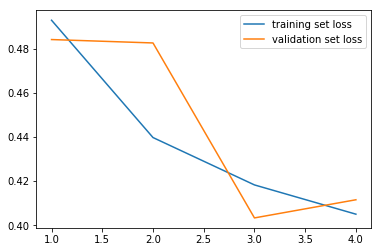

In [30]:
torch.save(final_detritus_model.state_dict(), './final_detritus_4')

# plot accuracy graph
plt.figure()
plt.plot(range(1, epoch + 1), train_loss_values, label='training set loss')
plt.plot(range(1, epoch + 1), test_loss_values, label='validation set loss')
plt.legend()
plt.show()

#### **Non detritus Final Model**

In [31]:
# weights for weighted random sampler

no_detritus_df = plankton_df[plankton_df['level2'] != 'detritus']

X_no_d = no_detritus_df['objid']
y_no_d = no_detritus_df['level2']

X_nodet_train, X_nodet_test, y_nodet_train, y_nodet_test = train_test_split(X_no_d, y_no_d, test_size=0.15, stratify=y_no_d)

#weights_df = no_detritus_df[no_detritus_df['objid'].isin(X_nodet_train.values)] # assign weights only to samples in the training set
weights_df = pd.DataFrame({'objid':X_nodet_train.values, 'level2': y_nodet_train.values})
weights_df['level2'] = weights_df['level2'].map(no_detritus_label_mapping)
weights_df['count'] = weights_df.groupby('level2')['level2'].transform('count')
weights_df['count'] = len(weights_df) / weights_df['count']
weights = weights_df['count'].values
weights = torch.DoubleTensor(weights)
no_detritus_wrs = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))

final_nodet_train_dataset = PlanktonDataset(X_nodet_train.values, y_nodet_train.values,
                                        img_files = img_files,
                                        label_mapping = no_detritus_label_mapping,
                                        transform = training_transformations,
                                        )

final_nodet_train_dataloader = DataLoader(final_nodet_train_dataset, batch_size=128, sampler=no_detritus_wrs, num_workers=4)

final_nodet_val_dataset = PlanktonDataset(X_nodet_test.values, y_nodet_test.values,
                                        img_files = img_files,
                                        label_mapping = no_detritus_label_mapping,
                                        transform = test_transformations,
                                        )

final_nodet_val_dataloader = DataLoader(final_nodet_val_dataset, batch_size=128, num_workers=4)

In [32]:
# first we train the model who classifies only detritus

final_n_detritus_model = NonDetritusModel().to(device)
final_n_detritus_model.zero_grad()
final_n_detritus_model.train()

loss_function = nn.NLLLoss()

# Confusions matrix analysis
n_classes = 38

optimizer = torch.optim.Adam(final_n_detritus_model.parameters())

test_loss_values = []
train_loss_values = []

epoch = 30

for e in tqdm(range(epoch)):
    # training
    avg_loss = train_model(final_nodet_train_dataloader, final_n_detritus_model, optimizer, loss_function)

    correct, confusion_matrix, accuracies, avg_loss_test = test_model(final_nodet_val_dataloader, final_n_detritus_model, loss_function, n_classes)
    mean_accuracy = np.mean(accuracies)
    accuracy = correct / len(y_nodet_test)
    
    print("Epoch {0}. Accuracy: {1}. Mean Accuracy: {2}. Avg Loss train: {3}. Avg Loss test: {4}".format(e + 1, round(accuracy, 4), mean_accuracy, avg_loss, avg_loss_test))
    test_loss_values.append(avg_loss_test)
    train_loss_values.append(avg_loss)

# final_n_detritus_model.save(final_n_detritus_model.state_dict(), './final_nodetritus_30')

# plot accuracy graph
plt.figure()
plt.plot(range(1, epoch + 1), train_loss_values, label='training set loss')
plt.plot(range(1, epoch + 1), test_loss_values, label='validation set loss')
plt.legend()
plt.show()

 20%|██        | 1/5 [02:13<08:53, 133.45s/it]

Epoch 1. Accuracy: 0.267. Mean Accuracy: 32.2496880728242. Avg Loss train: 2.41331201430001. Avg Loss test: 2.318747849968391


 40%|████      | 2/5 [04:30<06:43, 134.59s/it]

Epoch 2. Accuracy: 0.4313. Mean Accuracy: 44.399433694299375. Avg Loss train: 1.8708819412771678. Avg Loss test: 1.8316265897053043


 60%|██████    | 3/5 [06:50<04:32, 136.15s/it]

Epoch 3. Accuracy: 0.4423. Mean Accuracy: 49.57531931516324. Avg Loss train: 1.6018868808801463. Avg Loss test: 1.82356684479287


 80%|████████  | 4/5 [09:07<02:16, 136.43s/it]

Epoch 4. Accuracy: 0.5195. Mean Accuracy: 51.71048171160492. Avg Loss train: 1.4200901945546873. Avg Loss test: 1.5260258525367674


100%|██████████| 5/5 [11:24<00:00, 136.70s/it]

Epoch 5. Accuracy: 0.4795. Mean Accuracy: 54.54267096683386. Avg Loss train: 1.3147343045714273. Avg Loss test: 1.6666251159295804


AttributeError: 'NonDetritusModel' object has no attribute 'save'

F1 Score

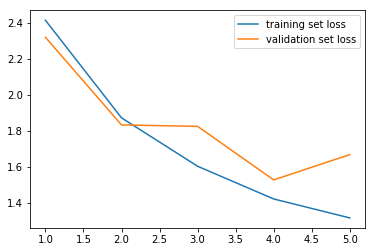

In [33]:
torch.save(final_n_detritus_model.state_dict(), './final_n_detritus_5')

# plot accuracy graph
plt.figure()
plt.plot(range(1, epoch + 1), train_loss_values, label='training set loss')
plt.plot(range(1, epoch + 1), test_loss_values, label='validation set loss')
plt.legend()
plt.show()

In [37]:
f1_dataset = PlanktonDataset(X_nodet_test.values, y_nodet_test.values,
                                img_files=img_files, label_mapping=detritus_mapping,
                                 transform = test_transformations)

f1_dataloader = DataLoader(f1_dataset, batch_size=1, num_workers=4)

print('Final F1 Score:', get_f1_score_hierarchical(f1_dataloader, final_detritus_model, final_n_detritus_model))

15626it [01:31, 170.50it/s]

Final F1 Score: (0.5065972920694373, 0.3016592131920774)


  8%|▊         | 1/12 [02:18<25:22, 138.43s/it]

Epoch 15. Accuracy: 0.6068. Mean Accuracy: 64.44024785731634. Avg Loss train: 0.9091921624420696. Avg Loss test: 1.2325755948942851


 17%|█▋        | 2/12 [04:35<22:58, 137.89s/it]

Epoch 16. Accuracy: 0.6048. Mean Accuracy: 63.14648633309546. Avg Loss train: 0.8791576879734249. Avg Loss test: 1.2638706516444198


 25%|██▌       | 3/12 [06:53<20:42, 138.03s/it]

Epoch 17. Accuracy: 0.6016. Mean Accuracy: 62.48875035782189. Avg Loss train: 0.8668618561387751. Avg Loss test: 1.2626113096872966


 33%|███▎      | 4/12 [09:11<18:24, 138.11s/it]

Epoch 18. Accuracy: 0.6218. Mean Accuracy: 63.5472992640447. Avg Loss train: 0.8489616174746111. Avg Loss test: 1.2072272678700888


 42%|████▏     | 5/12 [11:28<16:04, 137.78s/it]

Epoch 19. Accuracy: 0.6173. Mean Accuracy: 62.93348733053856. Avg Loss train: 0.8399225935081526. Avg Loss test: 1.2053113007933143


 50%|█████     | 6/12 [13:46<13:47, 137.84s/it]

Epoch 20. Accuracy: 0.6513. Mean Accuracy: 62.79280172112208. Avg Loss train: 0.8159245374058023. Avg Loss test: 1.1010594741115725


 58%|█████▊    | 7/12 [16:06<11:31, 138.29s/it]

Epoch 21. Accuracy: 0.6343. Mean Accuracy: 66.18434367970907. Avg Loss train: 0.8007822321846306. Avg Loss test: 1.1412868242922838


 67%|██████▋   | 8/12 [18:22<09:11, 137.86s/it]

Epoch 22. Accuracy: 0.6403. Mean Accuracy: 65.67340825214846. Avg Loss train: 0.8023953816794247. Avg Loss test: 1.127577675551903


 75%|███████▌  | 9/12 [20:39<06:52, 137.63s/it]

Epoch 23. Accuracy: 0.6332. Mean Accuracy: 65.1762466240631. Avg Loss train: 0.7832749957983205. Avg Loss test: 1.1772591389291656


 83%|████████▎ | 10/12 [22:57<04:35, 137.54s/it]

Epoch 24. Accuracy: 0.6482. Mean Accuracy: 65.24568097223478. Avg Loss train: 0.7731336539105184. Avg Loss test: 1.1145764749224594


 92%|█████████▏| 11/12 [25:16<02:17, 137.95s/it]

Epoch 25. Accuracy: 0.6549. Mean Accuracy: 65.06781292792421. Avg Loss train: 0.7690708260832494. Avg Loss test: 1.089762115866188


100%|██████████| 12/12 [27:36<00:00, 138.61s/it]

Epoch 26. Accuracy: 0.6613. Mean Accuracy: 65.76097605002762. Avg Loss train: 0.7520686771742181. Avg Loss test: 1.07666418174418


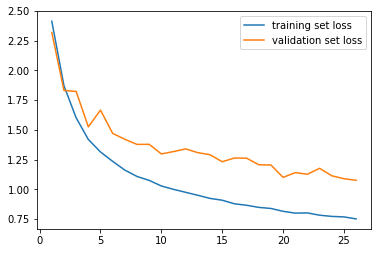

15626it [01:31, 171.07it/s]


Final F1 Score: (0.6590484631872755, 0.40515637006269)


In [39]:
add_epoch = 12

for e in tqdm(range(add_epoch)):
    # training
    avg_loss = train_model(final_nodet_train_dataloader, final_n_detritus_model, optimizer, loss_function)

    correct, confusion_matrix, accuracies, avg_loss_test = test_model(final_nodet_val_dataloader, final_n_detritus_model, loss_function, n_classes)
    mean_accuracy = np.mean(accuracies)
    accuracy = correct / len(y_nodet_test)
    
    print("Epoch {0}. Accuracy: {1}. Mean Accuracy: {2}. Avg Loss train: {3}. Avg Loss test: {4}".format(epoch + e + 1, round(accuracy, 4), mean_accuracy, avg_loss, avg_loss_test))
    test_loss_values.append(avg_loss_test)
    train_loss_values.append(avg_loss)

epoch += add_epoch

torch.save(final_n_detritus_model.state_dict(), './final_n_detritus_12')

# plot accuracy graph
plt.figure()
plt.plot(range(1, epoch + 1), train_loss_values, label='training set loss')
plt.plot(range(1, epoch + 1), test_loss_values, label='validation set loss')
plt.legend()
plt.show()
print('Final F1 Score:', get_f1_score_hierarchical(f1_dataloader, final_detritus_model, final_n_detritus_model))

In [33]:
# weights for weighted random sampler

# final_df = plankton_df

# X_ = final_df['objid']
# y_ = final_df['level2']

# #X_nodet_train, X_nodet_test, y_nodet_train, y_nodet_test = train_test_split(X_no_d, y_no_d, test_size=0.15, stratify=y_no_d)

#weights_df = no_detritus_df[no_detritus_df['objid'].isin(X_train.values)] # assign weights only to samples in the training set
weights_df = pd.DataFrame({'objid': X_train.values, 'level2': y_train.values})
weights_df['level2'] = weights_df['level2'].map(label_mapping)
weights_df['count'] = weights_df.groupby('level2')['level2'].transform('count')
weights_df['count'] = len(weights_df) / weights_df['count']
weights = weights_df['count'].values
weights = torch.DoubleTensor(weights)

planktop_wrs = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights), replacement=True)

final_train_dataset = PlanktonDataset(X_train.values, y_train.values,
                                        img_files=img_files,
                                        label_mapping=label_mapping,
                                        transform=training_transformations,
                                        )

final_train_dataloader = DataLoader(final_train_dataset, batch_size=128, sampler=planktop_wrs, num_workers=4)

final_val_dataset = PlanktonDataset(X_test.values, y_test.values,
                                        img_files=img_files,
                                        label_mapping=label_mapping,
                                        transform=test_transformations,
                                        )

final_val_dataloader = DataLoader(final_val_dataset, batch_size=128, num_workers=4)

  3%|▎         | 1/30 [03:10<1:31:55, 190.19s/it]

Epoch 1. Accuracy: 0.2581. Mean Accuracy: 44.939313264478336. Avg Loss train: 2.1221593409111126. Avg Loss test: 2.565989911765383


  7%|▋         | 2/30 [06:22<1:29:03, 190.85s/it]

Epoch 2. Accuracy: 0.3249. Mean Accuracy: 52.99933638724913. Avg Loss train: 1.5375067252970807. Avg Loss test: 2.3167693589863023


 10%|█         | 3/30 [09:34<1:25:59, 191.11s/it]

Epoch 3. Accuracy: 0.3447. Mean Accuracy: 56.91211330881659. Avg Loss train: 1.3194688132249983. Avg Loss test: 2.1563818864655078


 13%|█▎        | 4/30 [12:48<1:23:12, 192.03s/it]

Epoch 4. Accuracy: 0.3757. Mean Accuracy: 50.30622629267264. Avg Loss train: 1.2122059044781748. Avg Loss test: 2.1509203329420927


 17%|█▋        | 5/30 [16:03<1:20:24, 192.97s/it]

Epoch 5. Accuracy: 0.3846. Mean Accuracy: 60.99292922981586. Avg Loss train: 1.1427970648403498. Avg Loss test: 2.0306515886072525


 20%|██        | 6/30 [19:10<1:16:24, 191.01s/it]

Epoch 6. Accuracy: 0.3633. Mean Accuracy: 61.57841206271969. Avg Loss train: 1.0934694140927668. Avg Loss test: 2.131507848856742


 23%|██▎       | 7/30 [22:20<1:13:08, 190.80s/it]

Epoch 7. Accuracy: 0.377. Mean Accuracy: 62.06424407380147. Avg Loss train: 1.049314320161384. Avg Loss test: 2.0199480437395865


 27%|██▋       | 8/30 [25:28<1:09:43, 190.14s/it]

Epoch 8. Accuracy: 0.3702. Mean Accuracy: 66.77784959481872. Avg Loss train: 1.0161990187969752. Avg Loss test: 2.118655552780419


 30%|███       | 9/30 [28:42<1:06:55, 191.21s/it]

Epoch 9. Accuracy: 0.4473. Mean Accuracy: 64.63055348201068. Avg Loss train: 0.9902103370235812. Avg Loss test: 1.7869875824242307


 33%|███▎      | 10/30 [31:59<1:04:15, 192.75s/it]

Epoch 10. Accuracy: 0.4245. Mean Accuracy: 64.20474572742864. Avg Loss train: 0.9673805531142071. Avg Loss test: 1.880439727766472


 37%|███▋      | 11/30 [35:10<1:00:57, 192.48s/it]

Epoch 11. Accuracy: 0.4197. Mean Accuracy: 67.98573338135499. Avg Loss train: 0.9509752048526153. Avg Loss test: 1.9545649888222678


 40%|████      | 12/30 [38:21<57:36, 192.03s/it]  

Epoch 12. Accuracy: 0.4403. Mean Accuracy: 65.79476791765721. Avg Loss train: 0.9285547690784961. Avg Loss test: 1.8137941281000773


 43%|████▎     | 13/30 [41:30<54:07, 191.03s/it]

Epoch 13. Accuracy: 0.4313. Mean Accuracy: 65.19266723921376. Avg Loss train: 0.9107370394335196. Avg Loss test: 1.8920736986294127


 47%|████▋     | 14/30 [44:43<51:06, 191.63s/it]

Epoch 14. Accuracy: 0.4296. Mean Accuracy: 65.74275808344895. Avg Loss train: 0.9080944831111. Avg Loss test: 1.8326498211475841


 50%|█████     | 15/30 [47:57<48:04, 192.31s/it]

Epoch 15. Accuracy: 0.4428. Mean Accuracy: 66.87709666712276. Avg Loss train: 0.8931908055807166. Avg Loss test: 1.755424496165493


 53%|█████▎    | 16/30 [51:10<44:53, 192.40s/it]

Epoch 16. Accuracy: 0.4001. Mean Accuracy: 67.37209848687547. Avg Loss train: 0.879258940777471. Avg Loss test: 1.9904644953577142


 57%|█████▋    | 17/30 [54:28<42:06, 194.31s/it]

Epoch 17. Accuracy: 0.4169. Mean Accuracy: 67.8440171410064. Avg Loss train: 0.8729211435498434. Avg Loss test: 1.910699347027561


 60%|██████    | 18/30 [57:36<38:26, 192.21s/it]

Epoch 18. Accuracy: 0.4541. Mean Accuracy: 66.30164023940172. Avg Loss train: 0.8679835251428502. Avg Loss test: 1.7670933359547665


 63%|██████▎   | 19/30 [1:00:45<35:04, 191.29s/it]

Epoch 19. Accuracy: 0.4425. Mean Accuracy: 67.07432047587415. Avg Loss train: 0.8476690043956411. Avg Loss test: 1.826997515193203


 67%|██████▋   | 20/30 [1:03:59<32:01, 192.16s/it]

Epoch 20. Accuracy: 0.455. Mean Accuracy: 67.36880727983502. Avg Loss train: 0.8474379970920884. Avg Loss test: 1.7829328800502577


 70%|███████   | 21/30 [1:07:15<28:58, 193.22s/it]

Epoch 21. Accuracy: 0.4277. Mean Accuracy: 67.49572820903539. Avg Loss train: 0.8333534981047841. Avg Loss test: 1.8761127028548927


 73%|███████▎  | 22/30 [1:10:27<25:44, 193.07s/it]

Epoch 22. Accuracy: 0.464. Mean Accuracy: 66.93307356282203. Avg Loss train: 0.8385131550633877. Avg Loss test: 1.757160200570759


 77%|███████▋  | 23/30 [1:13:39<22:28, 192.64s/it]

Epoch 23. Accuracy: 0.4141. Mean Accuracy: 67.47717840579635. Avg Loss train: 0.8228655869774428. Avg Loss test: 1.9392434584467035


 80%|████████  | 24/30 [1:16:48<19:09, 191.57s/it]

Epoch 24. Accuracy: 0.486. Mean Accuracy: 66.69148974831563. Avg Loss train: 0.8185673937682183. Avg Loss test: 1.6391797450550816


 83%|████████▎ | 25/30 [1:20:01<15:59, 191.82s/it]

Epoch 25. Accuracy: 0.4694. Mean Accuracy: 68.56008410210138. Avg Loss train: 0.8079161778573067. Avg Loss test: 1.7465849993521707


 87%|████████▋ | 26/30 [1:23:11<12:45, 191.40s/it]

Epoch 26. Accuracy: 0.4307. Mean Accuracy: 68.77083228067967. Avg Loss train: 0.8069339051435958. Avg Loss test: 1.8496737421604625


 90%|█████████ | 27/30 [1:26:26<09:37, 192.39s/it]

Epoch 27. Accuracy: 0.4391. Mean Accuracy: 68.15809583266886. Avg Loss train: 0.800007650540869. Avg Loss test: 1.8485944388205544


 93%|█████████▎| 28/30 [1:29:40<06:25, 192.87s/it]

Epoch 28. Accuracy: 0.4538. Mean Accuracy: 68.54604208541024. Avg Loss train: 0.8038625647648984. Avg Loss test: 1.7699072285702353


 97%|█████████▋| 29/30 [1:32:55<03:13, 193.49s/it]

Epoch 29. Accuracy: 0.4541. Mean Accuracy: 67.1058644987838. Avg Loss train: 0.7942176523893406. Avg Loss test: 1.7790993251298604


100%|██████████| 30/30 [1:36:06<00:00, 192.76s/it]

Epoch 30. Accuracy: 0.4717. Mean Accuracy: 67.01515838115562. Avg Loss train: 0.7900276402792623. Avg Loss test: 1.7303917550204093


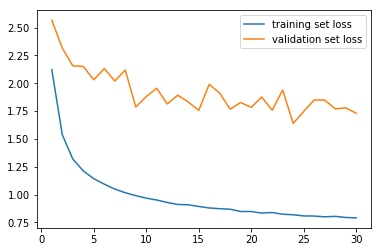

In [34]:
# first we train the model who classifies only detritus

final_plankton_model = PlanktonModel().to(device)
final_plankton_model.zero_grad()
final_plankton_model.train()

loss_function = nn.NLLLoss()

# Confusions matrix analysis
n_classes = 39

optimizer = torch.optim.Adam(final_plankton_model.parameters())

test_loss_values = []
train_loss_values = []

epoch = 30

for e in tqdm(range(epoch)):
    # training
    avg_loss = train_model(final_train_dataloader, final_plankton_model, optimizer, loss_function)

    correct, confusion_matrix, accuracies, avg_loss_test = test_model(final_val_dataloader, final_plankton_model, loss_function, n_classes)
    mean_accuracy = np.mean(accuracies)
    accuracy = correct / len(y_test)
    
    print("Epoch {0}. Accuracy: {1}. Mean Accuracy: {2}. Avg Loss train: {3}. Avg Loss test: {4}".format(e + 1, round(accuracy, 4), mean_accuracy, avg_loss, avg_loss_test))
    test_loss_values.append(avg_loss_test)
    train_loss_values.append(avg_loss)

# final_n_detritus_model.save(final_n_detritus_model.state_dict(), './final_nodetritus_30')
torch.save(final_plankton_model.state_dict(), './final_plankton_30')

# plot accuracy graph
plt.figure()
plt.plot(range(1, epoch + 1), train_loss_values, label='training set loss')
plt.plot(range(1, epoch + 1), test_loss_values, label='validation set loss')
plt.legend()
plt.show()

 10%|█         | 1/10 [03:12<28:50, 192.28s/it]

Epoch 1. Accuracy: 0.2629. Mean Accuracy: 41.613644315256444. Avg Loss train: 2.162178451902517. Avg Loss test: 2.567449985470688


 20%|██        | 2/10 [06:22<25:33, 191.72s/it]

Epoch 2. Accuracy: 0.2864. Mean Accuracy: 50.99450710983191. Avg Loss train: 1.6219649728267425. Avg Loss test: 2.4678004775130957


 30%|███       | 3/10 [09:33<22:20, 191.46s/it]

Epoch 3. Accuracy: 0.3179. Mean Accuracy: 54.36538087007578. Avg Loss train: 1.412600793850333. Avg Loss test: 2.281314612271493


 40%|████      | 4/10 [12:48<19:15, 192.57s/it]

Epoch 4. Accuracy: 0.3458. Mean Accuracy: 58.03766554697111. Avg Loss train: 1.2985052031559625. Avg Loss test: 2.2118310702474493


 50%|█████     | 5/10 [16:03<16:06, 193.28s/it]

Epoch 5. Accuracy: 0.3716. Mean Accuracy: 57.89757666974876. Avg Loss train: 1.2213218994900843. Avg Loss test: 2.130664258254202


 60%|██████    | 6/10 [19:18<12:55, 193.89s/it]

Epoch 6. Accuracy: 0.3756. Mean Accuracy: 60.83024195719345. Avg Loss train: 1.1671819657678935. Avg Loss test: 2.0160210287361813


 70%|███████   | 7/10 [22:33<09:42, 194.12s/it]

Epoch 7. Accuracy: 0.3527. Mean Accuracy: 58.737483642798665. Avg Loss train: 1.1225566516443162. Avg Loss test: 2.2750498160981296


 80%|████████  | 8/10 [25:46<06:27, 193.86s/it]

Epoch 8. Accuracy: 0.377. Mean Accuracy: 60.73540026642255. Avg Loss train: 1.0912624458890992. Avg Loss test: 2.06284355782626


 90%|█████████ | 9/10 [29:01<03:14, 194.05s/it]

Epoch 9. Accuracy: 0.3992. Mean Accuracy: 61.66678819310713. Avg Loss train: 1.0574478461931716. Avg Loss test: 1.991424272353189


100%|██████████| 10/10 [32:14<00:00, 193.77s/it]

Epoch 10. Accuracy: 0.3777. Mean Accuracy: 62.71981020837034. Avg Loss train: 1.0296485444748076. Avg Loss test: 2.077572376267952


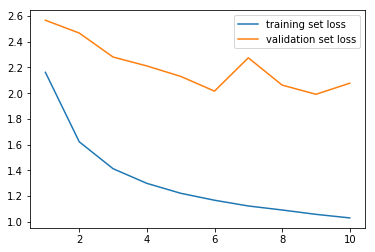

36392it [03:36, 167.94it/s]


Final F1 Score: (0.4214305804826424, 0.27877471122869985)


In [37]:
# first we train the model who classifies only detritus

final_plankton_model = PlanktonModel().to(device)
final_plankton_model.zero_grad()
final_plankton_model.train()

loss_function = nn.NLLLoss()

# Confusions matrix analysis
n_classes = 39

optimizer = torch.optim.Adam(final_plankton_model.parameters())

test_loss_values = []
train_loss_values = []

epoch = 10

for e in tqdm(range(epoch)):
    # training
    avg_loss = train_model(final_train_dataloader, final_plankton_model, optimizer, loss_function)

    correct, confusion_matrix, accuracies, avg_loss_test = test_model(final_val_dataloader, final_plankton_model, loss_function, n_classes)
    mean_accuracy = np.mean(accuracies)
    accuracy = correct / len(y_test)
    
    print("Epoch {0}. Accuracy: {1}. Mean Accuracy: {2}. Avg Loss train: {3}. Avg Loss test: {4}".format(e + 1, round(accuracy, 4), mean_accuracy, avg_loss, avg_loss_test))
    test_loss_values.append(avg_loss_test)
    train_loss_values.append(avg_loss)

# final_n_detritus_model.save(final_n_detritus_model.state_dict(), './final_nodetritus_30')
torch.save(final_plankton_model.state_dict(), './final_plankton_10')

# plot accuracy graph
plt.figure()
plt.plot(range(1, epoch + 1), train_loss_values, label='training set loss')
plt.plot(range(1, epoch + 1), test_loss_values, label='validation set loss')
plt.legend()
plt.show()

f1_dataset = PlanktonDataset(X_test.values, y_test.values,
                            img_files=img_files, label_mapping=label_mapping,
                            transform=test_transformations)

f1_dataloader = DataLoader(f1_dataset, batch_size=1, num_workers=4)

print('Final F1 Score:', get_f1_score(f1_dataloader, final_plankton_model))

In [39]:
f1_dataset = PlanktonDataset(X_train.values, y_train.values,
                            img_files=img_files, label_mapping=label_mapping,
                            transform=test_transformations)

f1_dataloader = DataLoader(f1_dataset, batch_size=1, num_workers=4)

print('Final F1 Score:', get_f1_score(f1_dataloader, final_plankton_model))

206215it [22:32, 122.37it/s]


Final F1 Score: (0.42451551356782097, 0.2864605240674293)


In [35]:
f1_dataset = PlanktonDataset(X_train.values, y_train.values,
                            img_files=img_files, label_mapping=label_mapping,
                            transform=test_transformations)

f1_dataloader = DataLoader(f1_dataset, batch_size=1, num_workers=4)

print('Final F1 Score:', get_f1_score(f1_dataloader, final_plankton_model))

36392it [03:33, 170.73it/s]


Final F1 Score: (0.5301607310472912, 0.32074892897228174)


##### References
[1] Handcrafted vs. non-handcrafted features for computer vision classification 

## A word on final macro F1 score

The final F1 score seem to not reflect the mitigation techniques deployed to tackle the unbalanceness of the dataset. This can be explained by observing the distribution of classes in one minibatch:

In [ ]:
minibatch = next(iter(final_nodet_val_dataloader))
minibatch['label']

As it is possible to see, it seems that the minibatch still shows the same unbalanceness of the dataset, in spite of the use of weights (in fact the label 0, corresponding to feces, is prevalent, in the minibatch as it is in the dataset). The time remaining doesn't allow to investigate if the bug is present in the code of the library or in our own. We are confident that, if solved this bug, the general strategy towards the problem could allow to obtain a much better score. If the bug is inherent of the library, in a production environment this could be a possible workaround:
<ul>
    <li> the class Dataset provides 100 items per each class. The lenght of the virtual dataset is 100 * (number of classes). The method __getitem__ will return the sample i-th % (number of samples for its class). In this way the dataset will be balanced among every class, and the dataloader will provide addictional variance randomly flipping or rotating the image.</li>
</ul>

#### **Additional Experiments**

Detritus model

In [70]:
train_idx, val_idx = next(k_fold_split)

# weights for weighted random sampler
weights_df = plankton_df[plankton_df['objid'].isin(X_train.values[train_idx])] # assign weights only to samples in the training set
weights_df['level2'] = weights_df['level2'].map(detritus_mapping)
weights_df['count'] = weights_df.groupby('level2')['level2'].transform('count')
weights_df['count'] = len(weights_df) / weights_df['count']
weights = weights_df['count'].values
weights = torch.DoubleTensor(weights)
detritus_wrs = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))

detritus_train_dataset = PlanktonDataset(X_train.values[train_idx], y_train.values[train_idx],
                                        img_files = img_files,
                                        label_mapping = detritus_mapping,
                                        transform = training_transformations,
                                        )
detritus_train_dataloader = DataLoader(detritus_train_dataset, batch_size=128, sampler=detritus_wrs, num_workers=4)

detritus_val_dataset = PlanktonDataset(X_train.values[val_idx], y_train.values[val_idx],
                                        img_files = img_files,
                                        label_mapping = detritus_mapping,
                                        transform = test_transformations,
                                        )
detritus_val_dataloader = DataLoader(detritus_val_dataset, batch_size=128, num_workers=4)

In [ ]:
### Training of the model with weighted sampler

detritus_model = DetritusModel().to(device)
detritus_model.zero_grad()
detritus_model.train()

non_detritus_model = NonDetritusModel().to(device)
non_detritus_model.zero_grad()
non_detritus_model.train()

loss_function = nn.NLLLoss()

# Confusions matrix analysis
n_classes = 2

optimizer = torch.optim.Adam(detritus_model.parameters())

test_loss_values = []
train_loss_values = []

epoch = 32

for e in range(epoch):
    # training
    avg_loss = train_model(detritus_train_dataloader, detritus_model, optimizer, loss_function)

    correct, confusion_matrix, accuracies, avg_loss_test = test_model(detritus_val_dataloader, detritus_model, loss_function, n_classes)
    mean_accuracy = np.mean(accuracies)
    accuracy = correct / len(y_val)
    
    print("Epoch {0}. Accuracy: {1}. Mean Accuracy: {2}. Avg Loss train: {3}. Avg Loss test: {4}".format(e + 1, round(accuracy, 4), mean_accuracy, avg_loss, avg_loss_test))
    test_loss_values.append(avg_loss_test)
    train_loss_values.append(avg_loss)
    
    
df = pd.DataFrame({'x': range(1, epoch + 1), 'train loss': train_loss_values, 'test loss': test_loss_values})
for column in df.drop('x', axis=1):
    plt.plot(df['x'], df[column], label=column)

plt.show()

1370it [01:57, 11.67it/s]
242it [00:09, 24.42it/s]

Epoch 1. Accuracy: 0.7984. Mean Accuracy: 79.39826817184749. Avg Loss train: 0.48603559899939236. Avg Loss test: 0.4338906593312902



1370it [01:46, 12.85it/s]
242it [00:09, 25.96it/s]

Epoch 2. Accuracy: 0.7642. Mean Accuracy: 77.8669432752048. Avg Loss train: 0.4338131622893967. Avg Loss test: 0.4814686319552177



1370it [01:59, 11.42it/s]
242it [00:10, 22.71it/s]

Epoch 3. Accuracy: 0.817. Mean Accuracy: 80.55275131504322. Avg Loss train: 0.4157784873986766. Avg Loss test: 0.39762244921577866



1370it [02:02, 11.15it/s]
242it [00:09, 25.24it/s]

Epoch 4. Accuracy: 0.8099. Mean Accuracy: 80.99560254461406. Avg Loss train: 0.40376191395912725. Avg Loss test: 0.4133574761881316



1370it [01:45, 12.93it/s]
242it [00:09, 25.33it/s]

Epoch 5. Accuracy: 0.8234. Mean Accuracy: 81.75287310112547. Avg Loss train: 0.3989112958638337. Avg Loss test: 0.38840241865678266



1370it [01:56, 11.75it/s]
242it [00:09, 24.28it/s]

Epoch 6. Accuracy: 0.8207. Mean Accuracy: 82.16815017973296. Avg Loss train: 0.38868903027181206. Avg Loss test: 0.3950972101412529



1370it [02:04, 12.96it/s]
242it [00:10, 23.05it/s]

Epoch 7. Accuracy: 0.8244. Mean Accuracy: 81.48198399370976. Avg Loss train: 0.3870968387074714. Avg Loss test: 0.38437305507827396



1370it [02:17,  9.94it/s]
242it [00:10, 22.31it/s]


Epoch 8. Accuracy: 0.8316. Mean Accuracy: 82.81438428607893. Avg Loss train: 0.3812005673881865. Avg Loss test: 0.3704652865686692


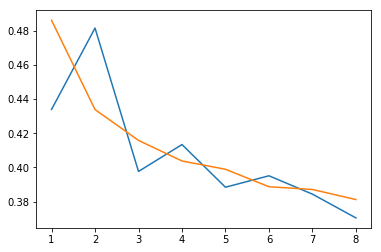

In [24]:
### Training of the model with weighted sampler

detritus_model = DetritusModel(injection_dim=3)

detritus_model = detritus_model.to(device)

loss_function = nn.NLLLoss()

# Confusions matrix analysis
n_classes = 2
confusion_matrix = np.zeros((n_classes, n_classes))

detritus_model.zero_grad()

detritus_model.train()

# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam(detritus_model.parameters())

test_loss_values = []
train_loss_values = []

epoch = 8

for e in range(epoch):
    #training
    trainer_iterator = iter(detritus_train_dataloader)
    tot_loss = 0
    for i, sample in tqdm(enumerate(trainer_iterator)):
        image = sample['image'].to(device)
        inj_features = sample['inj_features'].to(device)
        target = sample['label'].to(device)
        optimizer.zero_grad()
        output = detritus_model(image, inj_features)
        loss = loss_function(output, target)
        loss.backward()
        optimizer.step()
        tot_loss += loss.data.item()
    avg_loss = tot_loss / (i + 1)

    confusion_matrix = np.zeros((n_classes, n_classes))
    # Testing
    with torch.no_grad():
        tot_loss_test = 0
        correct = 0
        tester_iterator = iter(detritus_val_dataloader)
        for i, sample in tqdm(enumerate(tester_iterator)):
            image = sample['image'].to(device)
            inj_features = sample['inj_features'].to(device)
            target = sample['label'].to(device)
            output = detritus_model(image, inj_features)
            loss = loss_function(output, target)
            tot_loss_test += loss.data.item()
            pred = output.max(1, keepdim=True)[1]
            update_confusion_matrix(confusion_matrix, output, target, n_classes=n_classes)
            correct += pred.eq(target.view_as(pred)).sum().item()
        avg_loss_test = tot_loss_test / (i + 1)
        # per class accuracies
        accuracies = build_per_class_accuracies(confusion_matrix)
        mean_accuracy = np.mean(accuracies)
        accuracy = correct / len(y_val)
        print("Epoch {0}. Accuracy: {1}. Mean Accuracy: {2}. Avg Loss train: {3}. Avg Loss test: {4}".format(e + 1, round(accuracy, 4), mean_accuracy, avg_loss, avg_loss_test))
    #adding avg loss
    test_loss_values.append(avg_loss_test)
    train_loss_values.append(avg_loss)
    

    
df = pd.DataFrame({'x': range(1, epoch + 1), 'train loss': train_loss_values, 'test loss': test_loss_values})
for column in df.drop('x', axis=1):
    plt.plot(df['x'], df[column], label=column)
    
# torch.save(detritus_model.state_dict(), './detritus_model_8')

plt.show()

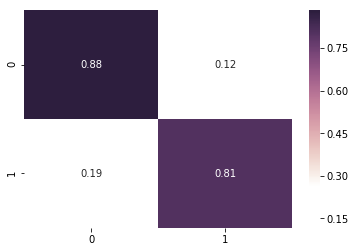

In [55]:
# Analyzing the last confusion matrix

confusion_matrix = confusion_matrix.astype(float)

ncm = confusion_matrix / confusion_matrix.sum(axis=1, keepdims=True)

# setting an appropriate color palette
cmap = sns.cubehelix_palette(light=1.2, as_cmap=True)
g = sns.heatmap(ncm, cmap=cmap, annot=True)

1370it [02:07, 10.73it/s]
242it [00:10, 22.87it/s]

Epoch 33. Accuracy: 0.849. Mean Accuracy: 84.53125832966921. Avg Loss train: 0.33224207291202823. Avg Loss test: 0.33272551012433266



1370it [02:20,  9.76it/s]
242it [00:10, 24.13it/s]

Epoch 34. Accuracy: 0.8473. Mean Accuracy: 84.35410320726811. Avg Loss train: 0.3312803233191915. Avg Loss test: 0.33402580681664884



1370it [02:19,  9.82it/s]
242it [00:10, 24.07it/s]

Epoch 35. Accuracy: 0.8488. Mean Accuracy: 84.49741521286617. Avg Loss train: 0.33307590852253627. Avg Loss test: 0.3300815507276984



1370it [02:17,  9.93it/s]
242it [00:10, 22.53it/s]

Epoch 36. Accuracy: 0.8513. Mean Accuracy: 84.67833610820844. Avg Loss train: 0.3311214269186458. Avg Loss test: 0.3287126949010802



1370it [02:17,  9.99it/s]
242it [00:10, 23.67it/s]

Epoch 37. Accuracy: 0.8488. Mean Accuracy: 84.53379244724789. Avg Loss train: 0.33105305039534605. Avg Loss test: 0.3319382025929522



1370it [02:17, 10.00it/s]
242it [00:10, 22.40it/s]

Epoch 38. Accuracy: 0.8493. Mean Accuracy: 84.56882861688169. Avg Loss train: 0.3293251518676751. Avg Loss test: 0.332918836989186



242it [00:09, 26.80it/s]

Epoch 39. Accuracy: 0.8497. Mean Accuracy: 84.74545993918409. Avg Loss train: 0.3301912523425409. Avg Loss test: 0.33356714956770256



1370it [02:10, 10.53it/s]
242it [00:09, 24.30it/s]


Epoch 40. Accuracy: 0.85. Mean Accuracy: 84.45597102296905. Avg Loss train: 0.3281226141500647. Avg Loss test: 0.32963784328423257


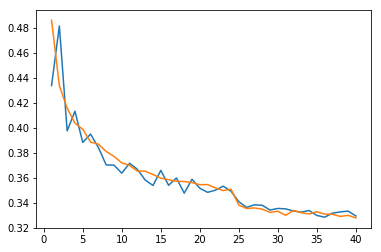

In [40]:
### Training of the model with weighted sampler

n_classes = 2
confusion_matrix = np.zeros((n_classes, n_classes))


optimizer = torch.optim.Adam(detritus_model.parameters(), lr=1e-4)

add_epoch = 8

for e in range(add_epoch):
    #training
    trainer_iterator = iter(detritus_train_dataloader)
    tot_loss = 0
    for i, sample in tqdm(enumerate(trainer_iterator)):
        image = sample['image'].to(device)
        inj_features = sample['inj_features'].to(device)
        target = sample['label'].to(device)
        optimizer.zero_grad()
        output = detritus_model(image, inj_features)
        loss = loss_function(output, target)
        loss.backward()
        optimizer.step()
        tot_loss += loss.data.item()
    avg_loss = tot_loss / (i + 1)

    confusion_matrix = np.zeros((n_classes, n_classes))
    # Testing
    with torch.no_grad():
        tot_loss_test = 0
        correct = 0
        tester_iterator = iter(detritus_val_dataloader)
        for i, sample in tqdm(enumerate(tester_iterator)):
            image = sample['image'].to(device)
            inj_features = sample['inj_features'].to(device)
            target = sample['label'].to(device)
            output = detritus_model(image, inj_features)
            loss = loss_function(output, target)
            tot_loss_test += loss.data.item()
            pred = output.max(1, keepdim=True)[1]
            update_confusion_matrix(confusion_matrix, output, target, n_classes=n_classes)
            correct += pred.eq(target.view_as(pred)).sum().item()
        avg_loss_test = tot_loss_test / (i + 1)
        # per class accuracies
        accuracies = build_per_class_accuracies(confusion_matrix)
        mean_accuracy = np.mean(accuracies)
        accuracy = correct / len(y_val)
        print("Epoch {0}. Accuracy: {1}. Mean Accuracy: {2}. Avg Loss train: {3}. Avg Loss test: {4}".format(epoch + e + 1, round(accuracy, 4), mean_accuracy, avg_loss, avg_loss_test))
    #adding avg loss
    test_loss_values.append(avg_loss_test)
    train_loss_values.append(avg_loss)
    
epoch += add_epoch
    
    
df = pd.DataFrame({'x': range(1, epoch + 1), 'train': train_loss_values, 'test': test_loss_values})
for column in df.drop('x', axis=1):
    plt.plot(df['x'], df[column], label=column)

plt.show()

In [ ]:
# Analyzing the last confusion matrix
confusion_matrix = np.array([[14937., 2714.], [ 2191., 11091.]])

# confusion_matrix = confusion_matrix.astype(float)

ncm = confusion_matrix / confusion_matrix.sum(axis=1, keepdims=True)

# setting an appropriate color palette
cmap = sns.cubehelix_palette(light=1.2, as_cmap=True)
g = sns.heatmap(ncm, cmap=cmap, annot=True)